In [ ]:
# EXCEL IMPORT LIBRARIES
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from google.colab import files, drive  # To download files, store them in drive
from tqdm import tqdm
from datetime import datetime, timedelta

# Linear Model + K
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import random
np.random.seed(42)
random.seed(42)

## Helper Functions

In [ ]:
from sklearn.metrics import accuracy_score

def calculate_directional_accuracy(y_true, y_pred):
    # Calculate the direction of actual prices (1 = up, 0 = down)
    actual_direction = (y_true[1:] > y_true[:-1]).astype(int)

#Calculate the direction of predicted prices (1 = up, 0 = down)
    predicted_direction = (y_pred[1:] > y_pred[:-1]).astype(int)

#Identify the days when the actual price trend changes
    trend_changes = (actual_direction[1:] != actual_direction[:-1]).astype(int)

#Filter the actual and predicted directions for trend change days
    actual_trend_change_days = actual_direction[1:][trend_changes == 1]
    predicted_trend_change_days = predicted_direction[1:][trend_changes == 1]

#Calculate directional accuracy for trend change days
    directional_accuracy = accuracy_score(actual_trend_change_days, predicted_trend_change_days)

    return directional_accuracy

In [ ]:
# # Function to create datasets for time-series predictions
# def create_dataset(data, time_step=1):
#     X, y = [], []
#     for i in range(len(data) - time_step - 1):
#         X.append(data[i:(i + time_step), 0])
#         y.append(data[i + time_step, 0])
#     return np.array(X), np.array(y)

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :-1])  # Use all columns except the last one for X
        y.append(data[i + time_step, -1])       # Use the last column for y
    return np.array(X), np.array(y)

In [ ]:
def custom_f1_score(y_true, y_pred, threshold=0.5):
    # Check if predicted values are within 50% of the true values
    lower_bound = y_true * (1 - threshold)
    upper_bound = y_true * (1 + threshold)

    # Create a binary classification: 1 for "correct" prediction, 0 for "incorrect"
    correct_predictions = ((y_pred >= lower_bound) & (y_pred <= upper_bound)).astype(int)

    # Return the F1 score
    return f1_score(correct_predictions, np.ones_like(correct_predictions))  # Only compare with the positive class (correct predictions)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = y_train[1:]  # Naive forecast assumes previous value
    naive_error = np.abs(naive_forecast - y_train[:-1])
    mae_naive = np.mean(naive_error)
    mae_model = np.mean(np.abs(y_true - y_pred))
    return mae_model / mae_naive

In [ ]:
def clamp(value, min_value):
    return max(min_value, value)

Graph Plotting Functions

In [ ]:
# Plotting Graphs
def drawGraphs(history, modelName, y_pred):
  # Loss function
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history[f'val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.title(f'{modelName} Loss')
  plt.legend()
  plt.show()

  # Mean Average Error
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['mae'], label='Training MAE')
  plt.plot(history.history[f'val_mae'], label='Validation MAE')
  plt.xlabel('Epochs')
  plt.title(f'{modelName} MAE')
  plt.legend()
  plt.show()

  # Price Prediction Graph
  plt.figure(figsize=(14, 7))
  plt.plot(y_test_inv, label='Actual Prices', color='black')
  plt.plot(y_pred, label=f'{modelName} Predictions', color='red')
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.title(f"{modelName} Stock Price Prediction")
  plt.legend()
  plt.show()

Function to show progress bar instead of outputting epochs on new line every time

In [ ]:
class TQDMProgressBar(Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        self.progress_bar = None

    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.epochs, desc='Training Progress', unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        self.progress_bar.set_postfix(loss=logs.get('loss'))

    def on_train_end(self, logs=None):
        self.progress_bar.close()

In [ ]:
# Fetching the data
ticker = 'NVDA'
data = yf.download(ticker)
data[['Open', 'High', 'Low', 'Close', 'Volume']]

print(data)

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                           NVDA        NVDA        NVDA        NVDA   
Date                                                                        
1999-01-22 00:00:00+00:00    0.037618    0.041016    0.048828    0.038802   
1999-01-25 00:00:00+00:00    0.041559    0.045313    0.045833    0.041016   
1999-01-26 00:00:00+00:00    0.038334    0.041797    0.046745    0.041146   
1999-01-27 00:00:00+00:00    0.038215    0.041667    0.042969    0.039583   
1999-01-28 00:00:00+00:00    0.038095    0.041536    0.041927    0.041276   
...                               ...         ...         ...         ...   
2024-11-11 00:00:00+00:00  145.259995  145.259995  148.850006  143.570007   
2024-11-12 00:00:00+00:00  148.289993  148.289993  149.649994  146.009995   
2024-11-13 00:00:00+00:00  146.270004  146.270004  149.330002  145.899994   
2024-11-14 00:00:00+00:00  146.759995  146.759995  149.000000  145.550003   

In [ ]:
# Use the 'Close' price as the target variable
data['Date'] = data.index
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(pd.Timestamp.toordinal)

# Features and target
X = data[['Volume','High','Low']]
y = data['Close']

# Combine features and target into a single DataFrame
data_combined = pd.concat([data[['Volume', 'High', 'Low']], y], axis=1)

Linear Regression

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions for the next day
last_day_data = data[['Volume', 'High', 'Low']].iloc[-1].values.reshape(1, -1)
next_day_prediction = model.predict(last_day_data)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Prediction for the next day:", next_day_prediction[0])
print("Mean Squared Error:", mse)

Prediction for the next day: [142.76134596]
Mean Squared Error: 0.1200029691355708


Select K Features

In [ ]:
# Select best features
best_features = SelectKBest(score_func=f_regression, k=3)
fit = best_features.fit(X, y)

# Get the scores for each feature
scores = fit.scores_
print(scores)

# Transform the features to select the best ones
X_best = best_features.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions for the next day
last_day_data = X_best[-1].reshape(1, -1)
next_day_prediction = model.predict(last_day_data)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Prediction for the next day:", next_day_prediction[0])
print("Mean Squared Error:", mse)

[1.38296084e+02 1.65251033e+07 2.33668185e+07]
Prediction for the next day: [142.76134596]
Mean Squared Error: 0.12000296913557065


CNN VS RNN VS LSTM

Preprocessing the data

In [ ]:
# Older preprocessing where we were only using closing price

# # Fit the scaler only on the target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# # Splitting the data into training and validation sets
# train_size = int(len(y_scaled) * 0.8)
# train_data, validation_data = y_scaled[:train_size], y_scaled[train_size:]

# # Creating datasets for training and testing
# time_step = 60
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(validation_data, time_step)

# # Reshaping the input data for RNN/LSTM models
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# # Invert the scaled target variable for visualization
# y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create separate scalers for features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit the scalers on the training data
X_scaled = scaler_X.fit_transform(data[['Volume', 'High', 'Low']])   ### !!! changed data_combined to just data -Evan 12:04 @ 11/16
y_scaled = scaler_y.fit_transform(data[['Close']])                   ### !!! changed data_combined to just data -Evan 12:04 @ 11/16

# Combine the scaled features and target
data_scaled = np.hstack((X_scaled, y_scaled))

# Split the data into training and validation sets
train_size = int(len(data_scaled) * 0.8)
train_data, validation_data = data_scaled[:train_size], data_scaled[train_size:]

# Create datasets for training and testing
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(validation_data, time_step)

# Reshape the input data for RNN/LSTM models
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Invert the scaled target variable for visualization
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

CNN MODEL

In [ ]:
while cnn_mse >= 15 or cnn_directional_accuracy <= 0.45:
  cnn_model = Sequential([
      Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(time_step, 3)),  # Adjust input_shape to (time_step, 3) from 1
      MaxPooling1D(pool_size=2),
      Dropout(0.2),
      Flatten(),
      Dense(50, activation='relu'),
      Dense(25, activation='relu'),
      Dense(1)
  ])

  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_cnn.keras'    # CHANGED My Drive TO MyDrive TO MATCH EVAN'S FILES
  # filePath = '/content/best_weights_cnn.keras'                         # REMOVED THIS BECAUSE IT WAS OVERRIDING THE PREVIOUS filepath AND WOULDNT WORK FOR EVAN
  filePath = '/content/drive/MyDrive/Project/best_weights_cnn_highMSE_highDir.keras'
  filePath = '/content/best_weights_cnn_highMSE_highDir.keras'

  # Compile and fit the CNN model
  cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #cnn_model.load_weights(filePath)

  early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
  progress_bar_cnn = TQDMProgressBar(epochs=50)  # Create the progress bar
  history_cnn = cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[progress_bar_cnn,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_cnn = scaler_y.inverse_transform(cnn_model.predict(X_test))
  cnn_mse = mean_squared_error(y_test_inv, y_pred_cnn)

  # Calculate directional accuracy
  cnn_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_cnn)
  print(f"CNN Model - Directional Accuracy: {cnn_directional_accuracy:.4f}")

  # Load existing model and check its MSE against current model
  cnn_model2 = load_model(filePath)
  y_pred_cnn2 = scaler_y.inverse_transform(cnn_model2.predict(X_test))
  cnn_mse2 = mean_squared_error(y_test_inv, y_pred_cnn2)
  cnn_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_cnn2)

  # Comment this out when not using the while loop
  if cnn_mse < (cnn_mse2) and cnn_directional_accuracy > clamp(cnn_directional_accuracy2 - 0.01, 0.45):
    cnn_model.save(filePath)
    print('saved')

# Save better model, load it's values
if cnn_mse < cnn_mse2 and cnn_directional_accuracy < cnn_directional_accuracy2:
  cnn_model.save(filePath)
else:
  cnn_model = cnn_model2
  y_pred_cnn = y_pred_cnn2
  cnn_mse = cnn_mse2

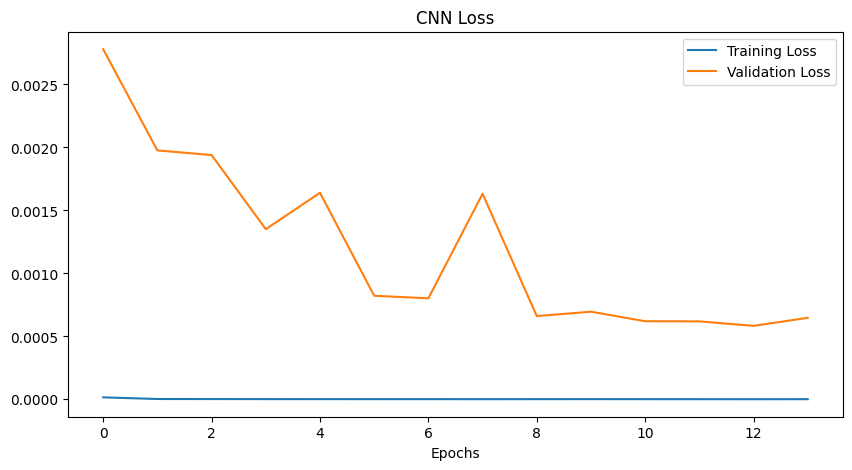

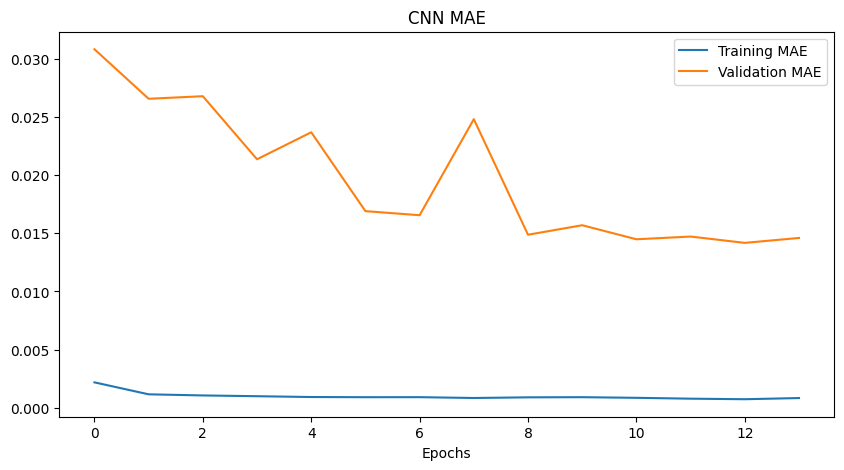

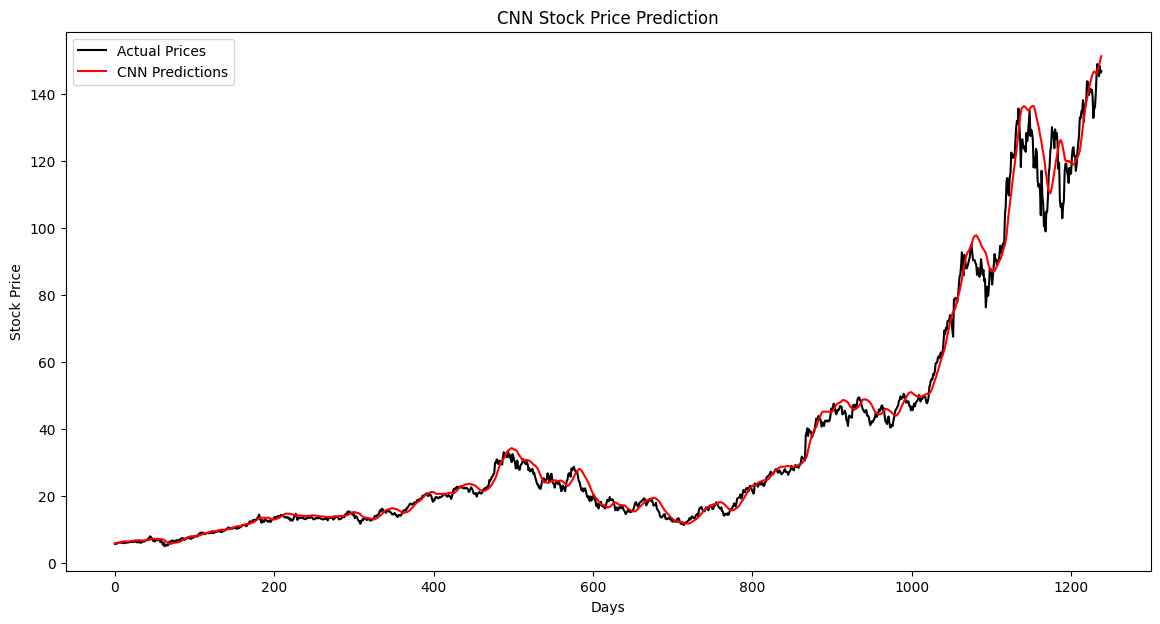

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_cnn, 'CNN', y_pred_cnn)

RNN MODEL

In [ ]:
# Run this loop until you get good results
#while rnn_mse >= 70 or rnn_directional_accuracy <= 0.46:
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=True, input_shape=(time_step, 3)),
    Dropout(0.1),
    SimpleRNN(50, activation='tanh', return_sequences=True),
    Dropout(0.1),
    SimpleRNN(50, activation='tanh', return_sequences=True),
    Dropout(0.1),
    SimpleRNN(50),
    Dropout(0.1),
    Dense(1)
])

# This is for older training data where we were only using close price as predictor.
# filePath = '/content/drive/MyDrive/Project/best_weights_rnn.keras'
# filePath = '/content/best_weights_rnn.keras'
filePath = '/content/drive/MyDrive/Project/best_weights_rnn_highMSE_highDir.keras'
filePath = '/content/best_weights_rnn_highMSE_highDir.keras'

# Compile and fit the Simple RNN model
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
#rnn_model.load_weights(filePath)

progress_bar_rnn = TQDMProgressBar(epochs=50)
history_rnn = rnn_model.fit(X_train, y_train, epochs=50, batch_size=8, callbacks=[progress_bar_rnn,early_stopping], validation_data=(X_test, y_test), verbose=0)

# Predict + Check the MSE
y_pred_rnn = scaler_y.inverse_transform(rnn_model.predict(X_test))
rnn_mse = mean_squared_error(y_test_inv, y_pred_rnn)

# Calculate directional accuracy
rnn_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_rnn)
print(f"RNN Model - Directional Accuracy: {rnn_directional_accuracy:.4f}")

# Load existing model and check its MSE against current model
rnn_model2 = load_model(filePath)
y_pred_rnn2 = scaler_y.inverse_transform(rnn_model2.predict(X_test))
rnn_mse2 = mean_squared_error(y_test_inv, y_pred_rnn2)
rnn_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_rnn2)

# Comment this out when not using the while loop
#if rnn_mse < (rnn_mse2) and rnn_directional_accuracy > clamp(rnn_directional_accuracy2 - 0.01, 0.46):
#  rnn_model.save(filePath)
#  print('saved')

# Save better model, load it's values
if rnn_mse < rnn_mse2 and rnn_directional_accuracy < rnn_directional_accuracy2:
  rnn_model.save(filePath)
else:
  rnn_model = rnn_model2
  y_pred_rnn = y_pred_rnn2
  rnn_mse = rnn_mse2

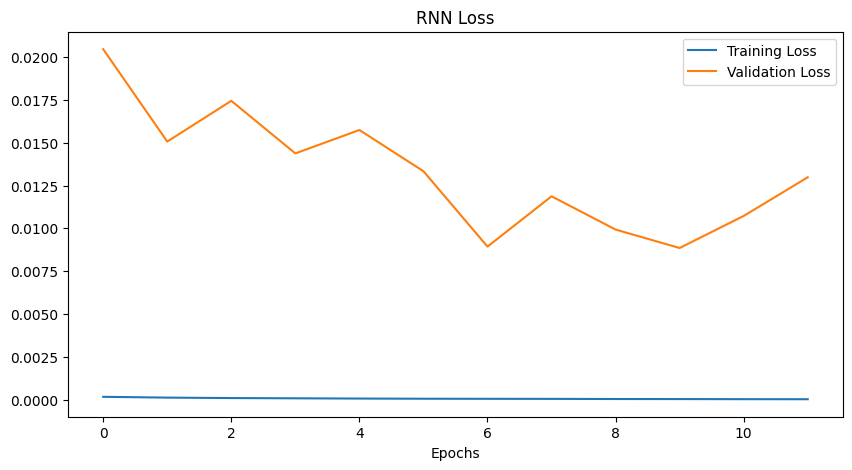

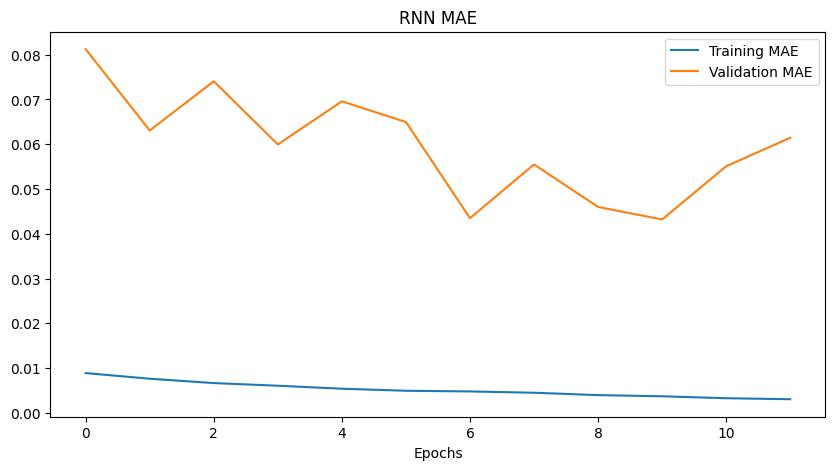

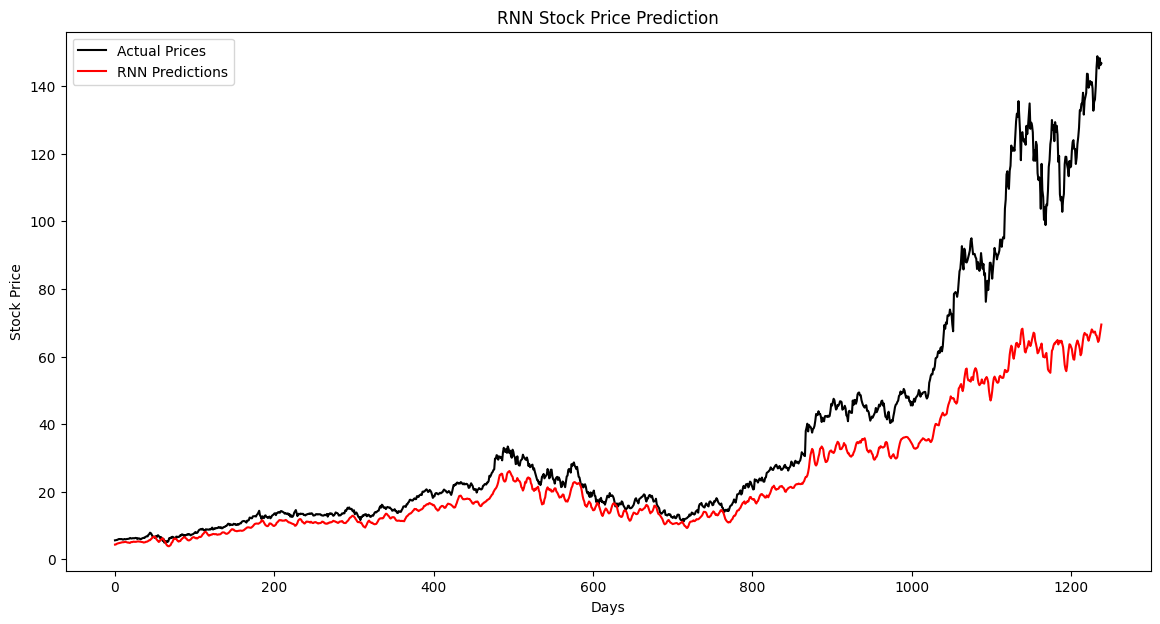

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_rnn, 'RNN', y_pred_rnn)

LSTM Model

In [ ]:
# If you want to get best mse + accuracy, uncomment this while loop and indent till
# "Load existing model and check" section

#while lstm_mse >= 7 or lstm_directional_accuracy <= 0.43:
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_step, 3)),
    LSTM(128),
    Dense(32),
    Dense(1)
])

# This is for older training data where we were only using close price as predictor.
# filePath = '/content/drive/MyDrive/Project/best_weights_lstm.keras'
# filePath = '/content/best_weights_lstm.keras'
filePath = '/content/drive/MyDrive/Project/best_weights_lstm_highMSE_highDir.keras'
filePath = '/content/best_weights_lstm_highMSE_highDir.keras'

# Compile and fit the LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
#lstm_model.load_weights(filePath)

progress_bar_lstm = TQDMProgressBar(epochs=10)
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=10, callbacks=[progress_bar_lstm,early_stopping], validation_data=(X_test, y_test), verbose=0)

# Predict + Check the MSE
y_pred_lstm = scaler_y.inverse_transform(lstm_model.predict(X_test))
lstm_mse = mean_squared_error(y_test_inv, y_pred_lstm)

# Calculate directional accuracy
lstm_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_lstm)
print(f"LSTM Model - Directional Accuracy: {lstm_directional_accuracy:.4f}")

# Load existing model and check its MSE against current model
lstm_model2 = load_model(filePath)
y_pred_lstm2 = scaler_y.inverse_transform(lstm_model2.predict(X_test))
lstm_mse2 = mean_squared_error(y_test_inv, y_pred_lstm2)
lstm_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_lstm2)

  # Comment this out when not using the while loop
 # if lstm_mse < (lstm_mse2) and lstm_directional_accuracy > clamp(lstm_directional_accuracy2 - 0.01, 0.43):
 #   lstm_model.save(filePath)
 #   print('saved')

# Save better model, load it's values
if lstm_mse < lstm_mse2 and lstm_directional_accuracy < lstm_directional_accuracy2:
  lstm_model.save(filePath)
else:
lstm_model = lstm_model2
y_pred_lstm = y_pred_lstm2
lstm_mse = lstm_mse2



Training Progress:   0%|          | 0/50 [1:29:11<?, ?epoch/s]


Training Progress:  10%|█         | 1/10 [00:22<03:25, 22.86s/epoch]

Training Progress:  10%|█         | 1/10 [00:22<03:25, 22.86s/epoch, loss=8.83e-7]

Training Progress:  20%|██        | 2/10 [00:31<01:55, 14.44s/epoch, loss=8.83e-7]

Training Progress:  20%|██        | 2/10 [00:31<01:55, 14.44s/epoch, loss=1.09e-6]

Training Progress:  30%|███       | 3/10 [00:36<01:12, 10.39s/epoch, loss=1.09e-6]

Training Progress:  30%|███       | 3/10 [00:36<01:12, 10.39s/epoch, loss=7.93e-7]

Training Progress:  40%|████      | 4/10 [00:41<00:48,  8.03s/epoch, loss=7.93e-7]

Training Progress:  40%|████      | 4/10 [00:41<00:48,  8.03s/epoch, loss=8.15e-7]

Training Progress:  50%|█████     | 5/10 [00:46<00:35,  7.02s/epoch, loss=8.15e-7]

Training Progress:  50%|█████     | 5/10 [00:46<00:35,  7.02s/epoch, loss=7.97e-7]

Training Progress:  60%|██████    | 6/10 [00:52<00:26,  6.59s/epoch, loss=7.97e-7]

Training Progress:  60%

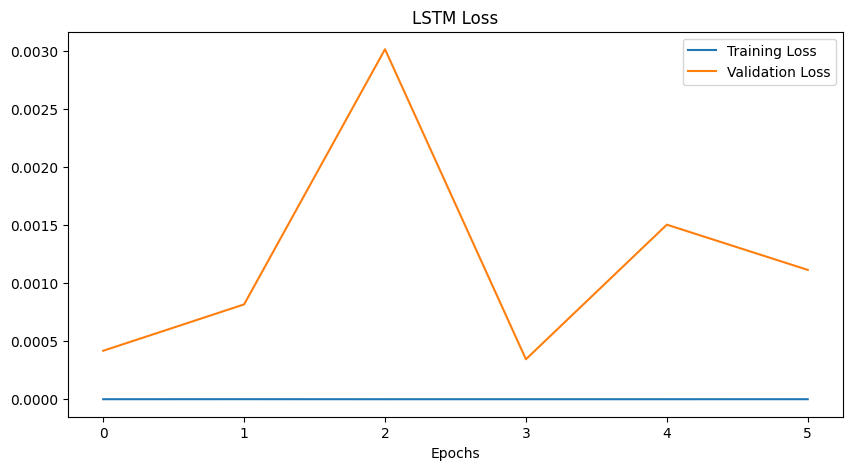

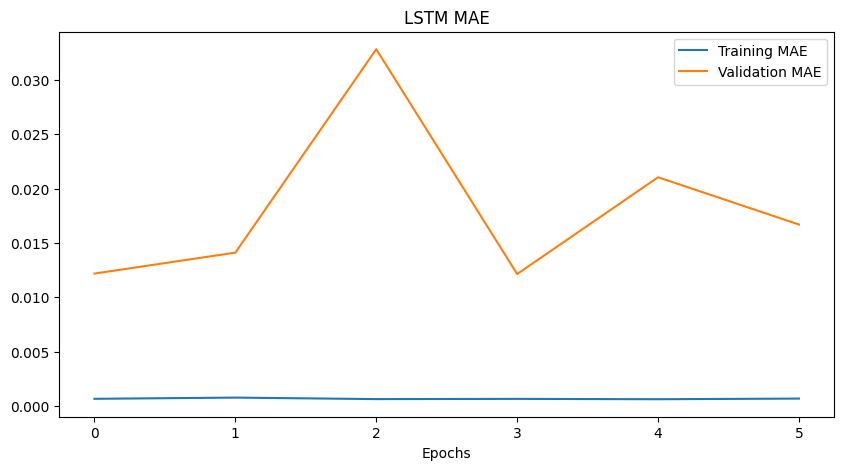

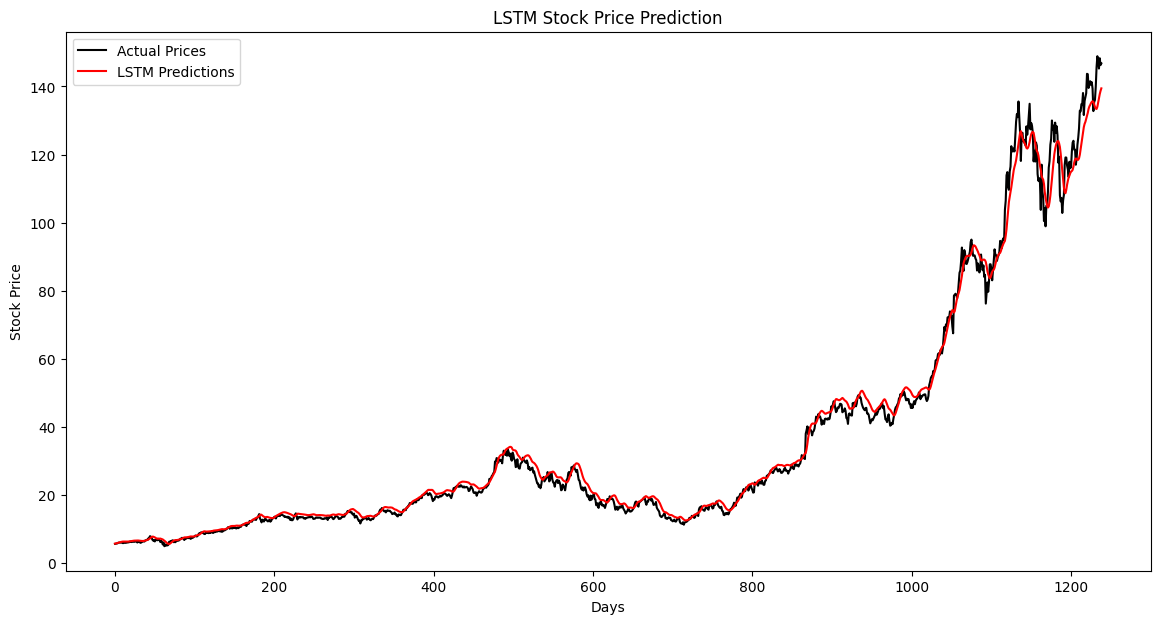

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_lstm, 'LSTM', y_pred_lstm)

GRU Model

In [ ]:
# If you want to get best mse + accuracy, uncomment this while loop and indent till
# "Load existing model and check" section
while gru_mse >= 80 or gru_directional_accuracy <= 0.47:
  gru_model = Sequential([
      GRU(100, activation='tanh', return_sequences=True, input_shape=(time_step, 3)),
      Dropout(0.3),
      GRU(100, activation='tanh', return_sequences=True),
      Dropout(0.3),
      GRU(100, activation='tanh', return_sequences=True),
      Dropout(0.3),
      GRU(100),
      Dropout(0.3),
      Dense(1)
  ])

  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_gru.keras'
  # filePath = '/content/best_weights_gru.keras'
  filePath = '/content/drive/MyDrive/Project/best_weights_gru_highMSE_highDir.keras'
  filePath = '/content/best_weights_gru_highMSE_highDir.keras'

  # Compile and fit the GRU model
  gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #gru_model.load_weights(filePath)

  progress_bar_gru = TQDMProgressBar(epochs=50)
  history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[progress_bar_gru,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_gru = scaler_y.inverse_transform(gru_model.predict(X_test))
  gru_mse = mean_squared_error(y_test_inv, y_pred_gru)

  # Calculate directional accuracy
  gru_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_gru)
  print(f"GRU Model - Directional Accuracy: {gru_directional_accuracy2:.4f}")

  # Load existing model and check its MSE against current model
  gru_model2 = load_model(filePath)
  y_pred_gru2 = scaler_y.inverse_transform(gru_model2.predict(X_test))
  gru_mse2 = mean_squared_error(y_test_inv, y_pred_gru2)
  gru_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_gru2)

  # # Comment this out when not using the while loop
  if gru_mse < (gru_mse2) and gru_directional_accuracy > clamp(gru_directional_accuracy2 - 0.01, 0.47):
    gru_model.save(filePath)
    print('saved')

# Save better model, load its values
if gru_mse < gru_mse2 and gru_directional_accuracy < gru_directional_accuracy2:
  gru_model.save(filePath)
else:
  gru_model = gru_model2
  y_pred_gru = y_pred_gru2
  gru_mse = gru_mse2

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_gru, 'GRU', y_pred_gru)

In [ ]:
# Visualization: CNN vs RNN vs LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='black')
plt.plot(y_pred_rnn, label='Simple RNN Predictions', color='purple')
plt.plot(y_pred_cnn, label='CNN Predictions', color='red')
plt.plot(y_pred_lstm, label='LSTM Predictions', color='orange')
plt.plot(y_pred_gru, label='GRU Predictions', color='pink')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Simple Models")
plt.legend()
plt.show()

Error Measurement

In [ ]:
# Calculate Mean Squared Error for evaluation
r_squared_cnn = r2_score(y_test_inv, y_pred_cnn)
r_squared_rnn = r2_score(y_test_inv, y_pred_rnn)
r_squared_lstm = r2_score(y_test_inv, y_pred_lstm)
r_squared_gru = r2_score(y_test_inv, y_pred_gru)

# Print MSE for each model
print(f'CNN Model MSE: {cnn_mse}')
print(f'CNN Model R^2:{r_squared_rnn}')
print()

print('=================')
print(f'Simple RNN Model MSE: {rnn_mse}')
print(f'Simple RNN Model R^2:{r_squared_rnn}')
print()

print('=================')
print()
print(f'LSTM Model MSE: {lstm_mse}')
print(f'LSTM Model R^2:{r_squared_lstm}')
print()

print('=================')
print()
print(f'GRU Model MSE: {gru_mse}')
print(f'GRU Model R^2:{r_squared_gru}')

CNN Model MSE: 18.46200870798543
Simple RNN Model MSE: 485.6306559372108
LSTM Model MSE: 9.355317292695128
GRU Model MSE: 91.98865275335298

MSE for Each Model:
RNN + LSTM Model MSE: 673.7180118383304
CNN + LSTM Model MSE: 91.47613007240435
CNN + RNN Model MSE: 93.09527248502218
RNN + CNN + LSTM Model MSE: 304.84615134742523



Price Predictions

In [ ]:
# Old prediction algo based solely on close price data
# # Future price prediction
# last_60_days = data[['Close']][-time_step:].values # Use only the 'Close' price for scaling
# last_60_days_scaled = scaler.transform(last_60_days)
# X_input = last_60_days_scaled.reshape(1, -1, 1)

# # Predictions with both models
# cnn_prediction = scaler.inverse_transform(cnn_model.predict(X_input))
# rnn_prediction = scaler.inverse_transform(rnn_model.predict(X_input))
# lstm_prediction = scaler.inverse_transform(lstm_model.predict(X_input))
# gru_prediction = scaler.inverse_transform(gru_model.predict(X_input))

# Future price prediction
last_60_days = data[['Volume', 'High', 'Low', 'Close']][-time_step:].values  # Use all features for scaling

# Scale the features (excluding 'Close' price)
last_60_days_scaled = scaler_X.transform(last_60_days[:, :-1])

# Reshape to (1, time_step, number_of_features)
X_input = last_60_days_scaled.reshape(1, time_step, last_60_days_scaled.shape[1])

# Predictions with all models
cnn_prediction = scaler_y.inverse_transform(cnn_model.predict(X_input))
rnn_prediction = scaler_y.inverse_transform(rnn_model.predict(X_input))
lstm_prediction = scaler_y.inverse_transform(lstm_model.predict(X_input))
gru_prediction = scaler_y.inverse_transform(gru_model.predict(X_input))

# Print predictions
print("Price Predictions by Each Model:")
print(f"CNN prediction for next day: {cnn_prediction[0, 0]}")
print(f"RNN prediction for next day: {rnn_prediction[0, 0]}")
print(f"LSTM prediction for next day: {lstm_prediction[0, 0]}")
print(f"GRU prediction for next day: {gru_prediction[0, 0]}")

In [ ]:
cnn_f1 = custom_f1_score(y_test_inv, y_pred_cnn, threshold=0.5)
rnn_f1 = custom_f1_score(y_test_inv, y_pred_rnn, threshold=0.5)
lstm_f1 = custom_f1_score(y_test_inv, y_pred_lstm, threshold=0.5)

print(f"CNN F1-Score (within 50%): {cnn_f1:.4f}")
print(f"RNN F1-Score (within 50%): {rnn_f1:.4f}")
print(f"LSTM F1-Score (within 50%): {lstm_f1:.4f}")

# graphing F1 scores
cnn_scores = [cnn_f1]
rnn_scores = [rnn_f1]
lstm_scores = [lstm_f1]

metrics = ['F1-Score']

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, cnn_scores, width, label='CNN')
rects2 = ax.bar(x, rnn_scores, width, label='RNN')
rects3 = ax.bar(x + width, lstm_scores, width, label='LSTM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: CNN, RNN, LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# Calculate MAPE for each model
cnn_mape = mean_absolute_percentage_error(y_test_inv, y_pred_cnn)
rnn_mape = mean_absolute_percentage_error(y_test_inv, y_pred_rnn)
lstm_mape = mean_absolute_percentage_error(y_test_inv, y_pred_lstm)

print(f"CNN MAPE: {cnn_mape:.2f}%")
print(f"RNN MAPE: {rnn_mape:.2f}%")
print(f"LSTM MAPE: {lstm_mape:.2f}%")

# # # # # # # # # # # # # # # # # # # # # # #

# Calculate RMSE for each model
cnn_rmse = root_mean_squared_error(y_test_inv, y_pred_cnn)
rnn_rmse = root_mean_squared_error(y_test_inv, y_pred_rnn)
lstm_rmse = root_mean_squared_error(y_test_inv, y_pred_lstm)

print(f"CNN RMSE: {cnn_rmse:.2f}")
print(f"RNN RMSE: {rnn_rmse:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")

# # # # # # # # # # # # # # # # # # # # # # #

# Calculate MASE for each model
cnn_mase = mean_absolute_scaled_error(y_test_inv, y_pred_cnn, train_data)
rnn_mase = mean_absolute_scaled_error(y_test_inv, y_pred_rnn, train_data)
lstm_mase = mean_absolute_scaled_error(y_test_inv, y_pred_lstm, train_data)

print(f"CNN MASE: {cnn_mase:.2f}")
print(f"RNN MASE: {rnn_mase:.2f}")
print(f"LSTM MASE: {lstm_mase:.2f}")

In [ ]:
metrics = ['MAPE', 'MSE', 'RMSE']
cnn_scores = [cnn_mape, cnn_mse, cnn_rmse]
rnn_scores = [rnn_mape, rnn_mse, rnn_rmse]
lstm_scores = [lstm_mape, lstm_mse, lstm_rmse]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, cnn_scores, width, label='CNN')
rects2 = ax.bar(x, rnn_scores, width, label='RNN')
rects3 = ax.bar(x + width, lstm_scores, width, label='LSTM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: CNN, RNN, LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# Graphing MASE seperately because its... too big
metrics = ['MASE']
cnn_scores = [cnn_mase]
rnn_scores = [rnn_mase]
lstm_scores = [lstm_mase]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, cnn_scores, width, label='CNN')
rects2 = ax.bar(x, rnn_scores, width, label='RNN')
rects3 = ax.bar(x + width, lstm_scores, width, label='LSTM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: CNN, RNN, LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
fig.tight_layout()
plt.show()

RNN + LSTM Hybrid Model

In [ ]:
# RNN + LSTM Hybrid Model
while rnn_lstm_mse >= 400 or rnn_lstm_directional_accuracy <= 0.47:
  rnn_lstm_model = Sequential([
      SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(time_step, 3)),
      SimpleRNN(128, activation='tanh', return_sequences=True),
      LSTM(64, return_sequences=False),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_rnn_lstm.keras'
  # filePath = '/content/best_weights_rnn_lstm.keras'
  filePath = '/content/drive/MyDrive/Project/best_weights_rnn_lstm_highMSE_highDir.keras'
  filePath = '/content/best_weights_rnn_lstm_highMSE_highDir.keras'

  # Compile and fit the RNN + LSTM model
  rnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #rnn_lstm_model.load_weights(filePath)

  progress_bar_rnn_lstm = TQDMProgressBar(epochs=20)
  history_rnn_lstm = rnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, callbacks=[progress_bar_rnn_lstm,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_rnn_lstm = scaler_y.inverse_transform(rnn_lstm_model.predict(X_test))
  rnn_lstm_mse = mean_squared_error(y_test_inv, y_pred_rnn_lstm)

  # Calculate directional accuracy
  rnn_lstm_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_rnn_lstm)
  print(f"RNN + LSTM Model - Directional Accuracy: {rnn_lstm_directional_accuracy:.4f}")

  # Load existing model and check its MSE against current model
  rnn_lstm_model2 = load_model(filePath)
  y_pred_rnn_lstm2 = scaler_y.inverse_transform(rnn_lstm_model2.predict(X_test))
  rnn_lstm_mse2 = mean_squared_error(y_test_inv, y_pred_rnn_lstm2)
  rnn_lstm_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_rnn_lstm2)

  # Comment this out when not using the while loop
  if rnn_lstm_mse < (rnn_lstm_mse2) and rnn_lstm_directional_accuracy > clamp(rnn_lstm_directional_accuracy2 - 0.01, 0.47):
    rnn_lstm_model.save(filePath)
    print('saved')

# Save better model, load it's values
if rnn_lstm_mse < rnn_lstm_mse2 and rnn_lstm_directional_accuracy > rnn_lstm_directional_accuracy2:
  rnn_lstm_model.save(filePath)
else:
  rnn_lstm_model = rnn_lstm_model2
  y_pred_rnn_lstm = y_pred_rnn_lstm2
  rnn_lstm_mse = rnn_lstm_mse2




Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:38,  8.33s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:38,  8.33s/epoch, loss=0.00111]


Training Progress:  10%|█         | 2/20 [00:15<02:05,  7.00s/epoch, loss=0.00111]


Training Progress:  10%|█         | 2/20 [00:15<02:05,  7.00s/epoch, loss=2.58e-5]


Training Progress:  15%|█▌        | 3/20 [00:24<02:25,  8.54s/epoch, loss=2.58e-5]


Training Progress:  15%|█▌        | 3/20 [00:24<02:25,  8.54s/epoch, loss=1.95e-5]


Training Progress:  20%|██        | 4/20 [00:31<02:03,  7.70s/epoch, loss=1.95e-5]


Training Progress:  20%|██        | 4/20 [00:31<02:03,  7.70s/epoch, loss=1.38e-5]


Training Progress:  25%|██▌       | 5/20 [00:39<01:54,  7.63s/epoch, loss=1.38e-5]


Training Progress:  25%|██▌       | 5/20 [00:39<01:57,  7.81s/epoch, loss=1.25e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RNN + LSTM Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:10<03:23, 10.71s/epoch]


Training Progress:   5%|▌         | 1/20 [00:10<03:23, 10.71s/epoch, loss=0.00106]


Training Progress:  10%|█         | 2/20 [00:20<03:04, 10.24s/epoch, loss=0.00106]


Training Progress:  10%|█         | 2/20 [00:20<03:04, 10.24s/epoch, loss=1.44e-5]


Training Progress:  15%|█▌        | 3/20 [00:27<02:25,  8.56s/epoch, loss=1.44e-5]


Training Progress:  15%|█▌        | 3/20 [00:27<02:25,  8.56s/epoch, loss=1.52e-5]


Training Progress:  20%|██        | 4/20 [00:34<02:08,  8.03s/epoch, loss=1.52e-5]


Training Progress:  20%|██        | 4/20 [00:34<02:08,  8.03s/epoch, loss=1.7e-5] 


Training Progress:  25%|██▌       | 5/20 [00:41<01:54,  7.64s/epoch, loss=1.7e-5]


Training Progress:  25%|██▌       | 5/20 [00:41<02:04,  8.27s/epoch, loss=1.3e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RNN + LSTM Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<02:41,  8.53s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<02:41,  8.53s/epoch, loss=0.000538]


Training Progress:  10%|█         | 2/20 [00:16<02:20,  7.80s/epoch, loss=0.000538]


Training Progress:  10%|█         | 2/20 [00:16<02:20,  7.80s/epoch, loss=1.47e-5] 


Training Progress:  15%|█▌        | 3/20 [00:23<02:05,  7.38s/epoch, loss=1.47e-5]


Training Progress:  15%|█▌        | 3/20 [00:23<02:05,  7.38s/epoch, loss=1.32e-5]


Training Progress:  20%|██        | 4/20 [00:33<02:14,  8.40s/epoch, loss=1.32e-5]


Training Progress:  20%|██        | 4/20 [00:33<02:14,  8.40s/epoch, loss=8.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:40<01:57,  7.84s/epoch, loss=8.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:40<02:00,  8.05s/epoch, loss=1.11e-5]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RNN + LSTM Model - Directional Accuracy: 0.5116
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.11s/epoch, loss=0.00592]


Training Progress:  10%|█         | 2/20 [00:15<02:14,  7.49s/epoch, loss=0.00592]


Training Progress:  10%|█         | 2/20 [00:15<02:14,  7.49s/epoch, loss=4.85e-5]


Training Progress:  15%|█▌        | 3/20 [00:21<01:57,  6.91s/epoch, loss=4.85e-5]


Training Progress:  15%|█▌        | 3/20 [00:21<01:57,  6.91s/epoch, loss=3.03e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:46,  6.68s/epoch, loss=3.03e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:46,  6.68s/epoch, loss=1.69e-5]


Training Progress:  25%|██▌       | 5/20 [00:37<01:58,  7.92s/epoch, loss=1.69e-5]


Training Progress:  25%|██▌       | 5/20 [00:37<01:53,  7.57s/epoch, loss=1.5e-5]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
RNN + LSTM Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.02s/epoch, loss=0.00068]


Training Progress:  10%|█         | 2/20 [00:14<02:06,  7.03s/epoch, loss=0.00068]


Training Progress:  10%|█         | 2/20 [00:14<02:06,  7.03s/epoch, loss=1.39e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:53,  6.67s/epoch, loss=1.39e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:53,  6.67s/epoch, loss=1.32e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:43,  6.48s/epoch, loss=1.32e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:43,  6.48s/epoch, loss=5.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:36<01:57,  7.81s/epoch, loss=5.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:36<01:50,  7.39s/epoch, loss=4.8e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RNN + LSTM Model - Directional Accuracy: 0.5198
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.03s/epoch, loss=0.000642]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.10s/epoch, loss=0.000642]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.10s/epoch, loss=2.57e-5] 


Training Progress:  15%|█▌        | 3/20 [00:20<01:54,  6.71s/epoch, loss=2.57e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:54,  6.71s/epoch, loss=2.35e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:43,  6.46s/epoch, loss=2.35e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:43,  6.46s/epoch, loss=2.31e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:34,  6.31s/epoch, loss=2.31e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:38,  6.57s/epoch, loss=1.31e-5]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RNN + LSTM Model - Directional Accuracy: 0.4620
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:32,  8.02s/epoch, loss=0.0026]


Training Progress:  10%|█         | 2/20 [00:14<02:05,  6.95s/epoch, loss=0.0026]


Training Progress:  10%|█         | 2/20 [00:14<02:05,  6.95s/epoch, loss=7.68e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:51,  6.59s/epoch, loss=7.68e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:51,  6.59s/epoch, loss=3.01e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.42s/epoch, loss=3.01e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.42s/epoch, loss=3.22e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:34,  6.32s/epoch, loss=3.22e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:38,  6.54s/epoch, loss=2.94e-5]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RNN + LSTM Model - Directional Accuracy: 0.4323
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:31,  7.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:31,  7.95s/epoch, loss=0.000804]


Training Progress:  10%|█         | 2/20 [00:15<02:12,  7.34s/epoch, loss=0.000804]


Training Progress:  10%|█         | 2/20 [00:15<02:12,  7.34s/epoch, loss=7.65e-6] 


Training Progress:  15%|█▌        | 3/20 [00:21<01:56,  6.87s/epoch, loss=7.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:56,  6.87s/epoch, loss=4.8e-6] 


Training Progress:  20%|██        | 4/20 [00:28<01:50,  6.88s/epoch, loss=4.8e-6]


Training Progress:  20%|██        | 4/20 [00:28<01:50,  6.88s/epoch, loss=5.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:34<01:43,  6.90s/epoch, loss=5.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:34<01:44,  7.00s/epoch, loss=5.76e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RNN + LSTM Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:35,  8.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:35,  8.16s/epoch, loss=0.000749]


Training Progress:  10%|█         | 2/20 [00:14<02:05,  6.99s/epoch, loss=0.000749]


Training Progress:  10%|█         | 2/20 [00:14<02:05,  6.99s/epoch, loss=3.67e-5] 


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.59s/epoch, loss=3.67e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.59s/epoch, loss=1.54e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.41s/epoch, loss=1.54e-5]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.41s/epoch, loss=1.78e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:34,  6.32s/epoch, loss=1.78e-5]


Training Progress:  25%|██▌       | 5/20 [00:32<01:38,  6.55s/epoch, loss=1.64e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
RNN + LSTM Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.13s/epoch, loss=0.00186]


Training Progress:  10%|█         | 2/20 [00:17<02:44,  9.13s/epoch, loss=0.00186]


Training Progress:  10%|█         | 2/20 [00:17<02:44,  9.13s/epoch, loss=0.000144]


Training Progress:  15%|█▌        | 3/20 [00:24<02:12,  7.81s/epoch, loss=0.000144]


Training Progress:  15%|█▌        | 3/20 [00:24<02:12,  7.81s/epoch, loss=2.04e-5] 


Training Progress:  20%|██        | 4/20 [00:34<02:19,  8.73s/epoch, loss=2.04e-5]


Training Progress:  20%|██        | 4/20 [00:34<02:19,  8.73s/epoch, loss=1.57e-5]


Training Progress:  25%|██▌       | 5/20 [00:40<01:56,  7.79s/epoch, loss=1.57e-5]


Training Progress:  25%|██▌       | 5/20 [00:40<02:01,  8.09s/epoch, loss=1.16e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
RNN + LSTM Model - Directional Accuracy: 0.5116
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:33,  8.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:33,  8.07s/epoch, loss=0.00104]


Training Progress:  10%|█         | 2/20 [00:14<02:06,  7.00s/epoch, loss=0.00104]


Training Progress:  10%|█         | 2/20 [00:14<02:06,  7.00s/epoch, loss=1.62e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.61s/epoch, loss=1.62e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.61s/epoch, loss=5.46e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.42s/epoch, loss=5.46e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:42,  6.42s/epoch, loss=4.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:32<01:34,  6.30s/epoch, loss=4.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:32<01:38,  6.54s/epoch, loss=4.95e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RNN + LSTM Model - Directional Accuracy: 0.5462
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:34,  8.14s/epoch, loss=0.00108]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.07s/epoch, loss=0.00108]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.07s/epoch, loss=0.000178]


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.64s/epoch, loss=0.000178]


Training Progress:  15%|█▌        | 3/20 [00:20<01:52,  6.64s/epoch, loss=0.00012] 


Training Progress:  20%|██        | 4/20 [00:27<01:43,  6.48s/epoch, loss=0.00012]


Training Progress:  20%|██        | 4/20 [00:27<01:43,  6.48s/epoch, loss=0.000162]


Training Progress:  25%|██▌       | 5/20 [00:33<01:38,  6.58s/epoch, loss=0.000162]


Training Progress:  25%|██▌       | 5/20 [00:33<01:41,  6.74s/epoch, loss=0.000144]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RNN + LSTM Model - Directional Accuracy: 0.4406
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<03:07,  9.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<03:07,  9.86s/epoch, loss=0.000607]


Training Progress:  10%|█         | 2/20 [00:16<02:19,  7.77s/epoch, loss=0.000607]


Training Progress:  10%|█         | 2/20 [00:16<02:19,  7.77s/epoch, loss=0.000615]


Training Progress:  15%|█▌        | 3/20 [00:22<02:01,  7.17s/epoch, loss=0.000615]


Training Progress:  15%|█▌        | 3/20 [00:22<02:01,  7.17s/epoch, loss=0.000133]


Training Progress:  20%|██        | 4/20 [00:29<01:48,  6.77s/epoch, loss=0.000133]


Training Progress:  20%|██        | 4/20 [00:29<01:48,  6.77s/epoch, loss=0.000129]


Training Progress:  25%|██▌       | 5/20 [00:35<01:41,  6.79s/epoch, loss=0.000129]


Training Progress:  25%|██▌       | 5/20 [00:35<01:47,  7.15s/epoch, loss=0.000132]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RNN + LSTM Model - Directional Accuracy: 0.3597
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:37,  8.30s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:37,  8.30s/epoch, loss=0.000868]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.11s/epoch, loss=0.000868]


Training Progress:  10%|█         | 2/20 [00:14<02:07,  7.11s/epoch, loss=4.07e-5] 


Training Progress:  15%|█▌        | 3/20 [00:21<01:53,  6.70s/epoch, loss=4.07e-5]


Training Progress:  15%|█▌        | 3/20 [00:21<01:53,  6.70s/epoch, loss=2.42e-5]


Training Progress:  20%|██        | 4/20 [00:28<01:47,  6.73s/epoch, loss=2.42e-5]


Training Progress:  20%|██        | 4/20 [00:28<01:47,  6.73s/epoch, loss=1.57e-5]


Training Progress:  25%|██▌       | 5/20 [00:34<01:41,  6.78s/epoch, loss=1.57e-5]


Training Progress:  25%|██▌       | 5/20 [00:34<01:43,  6.90s/epoch, loss=2.06e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
RNN + LSTM Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
saved





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:38,  8.36s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:38,  8.36s/epoch, loss=0.00133]


Training Progress:  10%|█         | 2/20 [00:15<02:14,  7.47s/epoch, loss=0.00133]


Training Progress:  10%|█         | 2/20 [00:15<02:14,  7.47s/epoch, loss=2.01e-5]


Training Progress:  15%|█▌        | 3/20 [00:22<02:05,  7.40s/epoch, loss=2.01e-5]


Training Progress:  15%|█▌        | 3/20 [00:22<02:05,  7.40s/epoch, loss=1.33e-5]


Training Progress:  20%|██        | 4/20 [00:29<01:55,  7.24s/epoch, loss=1.33e-5]


Training Progress:  20%|██        | 4/20 [00:29<01:55,  7.24s/epoch, loss=1.11e-5]


Training Progress:  25%|██▌       | 5/20 [00:36<01:45,  7.06s/epoch, loss=1.11e-5]


Training Progress:  25%|██▌       | 5/20 [00:36<01:50,  7.37s/epoch, loss=1.6e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
RNN + LSTM Model - Directional Accuracy: 0.5033
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<02:45,  8.73s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<02:45,  8.73s/epoch, loss=0.000466]


Training Progress:  10%|█         | 2/20 [00:16<02:18,  7.71s/epoch, loss=0.000466]


Training Progress:  10%|█         | 2/20 [00:16<02:18,  7.71s/epoch, loss=1.83e-5] 


Training Progress:  15%|█▌        | 3/20 [00:22<02:05,  7.36s/epoch, loss=1.83e-5]


Training Progress:  15%|█▌        | 3/20 [00:22<02:05,  7.36s/epoch, loss=1.47e-5]


Training Progress:  20%|██        | 4/20 [00:29<01:54,  7.16s/epoch, loss=1.47e-5]


Training Progress:  20%|██        | 4/20 [00:29<01:54,  7.16s/epoch, loss=1.65e-5]


Training Progress:  25%|██▌       | 5/20 [00:36<01:45,  7.04s/epoch, loss=1.65e-5]


Training Progress:  25%|██▌       | 5/20 [00:36<01:49,  7.27s/epoch, loss=1.22e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RNN + LSTM Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:08<02:35,  8.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:08<02:35,  8.18s/epoch, loss=0.00141]


Training Progress:  10%|█         | 2/20 [00:14<02:08,  7.11s/epoch, loss=0.00141]


Training Progress:  10%|█         | 2/20 [00:14<02:08,  7.11s/epoch, loss=3.62e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:55,  6.78s/epoch, loss=3.62e-5]


Training Progress:  15%|█▌        | 3/20 [00:20<01:55,  6.78s/epoch, loss=2.63e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:44,  6.54s/epoch, loss=2.63e-5]


Training Progress:  20%|██        | 4/20 [00:27<01:44,  6.54s/epoch, loss=2.48e-5]


Training Progress:  25%|██▌       | 5/20 [00:33<01:36,  6.44s/epoch, loss=2.48e-5]


Training Progress:  25%|██▌       | 5/20 [00:33<01:40,  6.68s/epoch, loss=2.22e-5]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
RNN + LSTM Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
saved


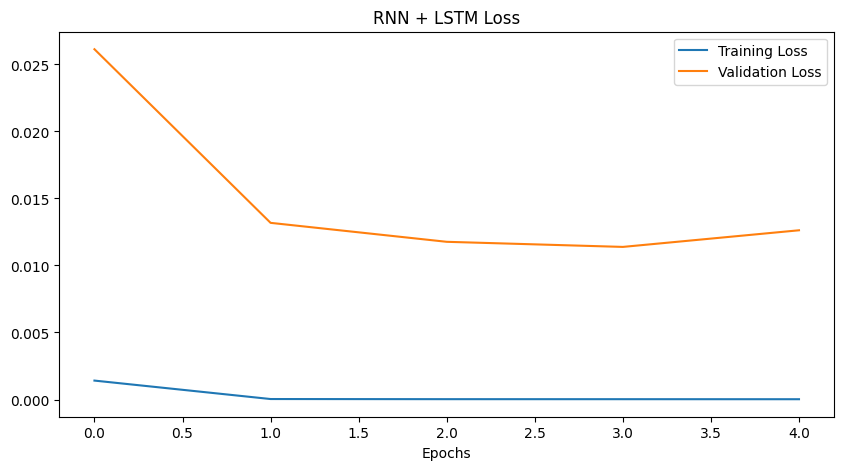

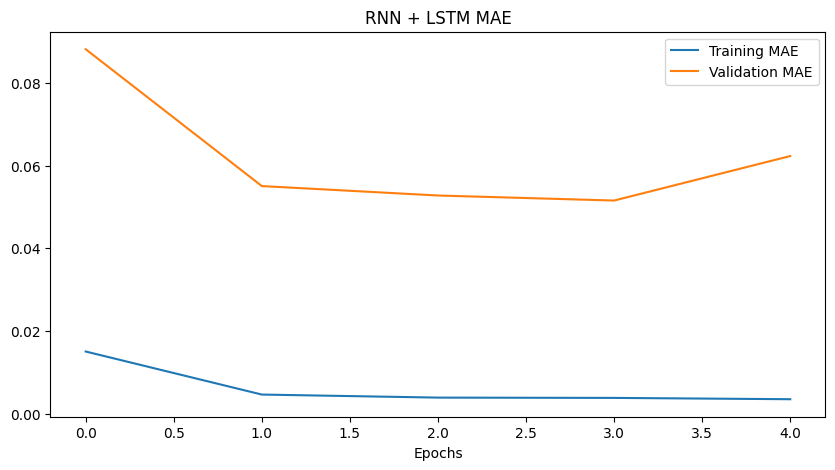

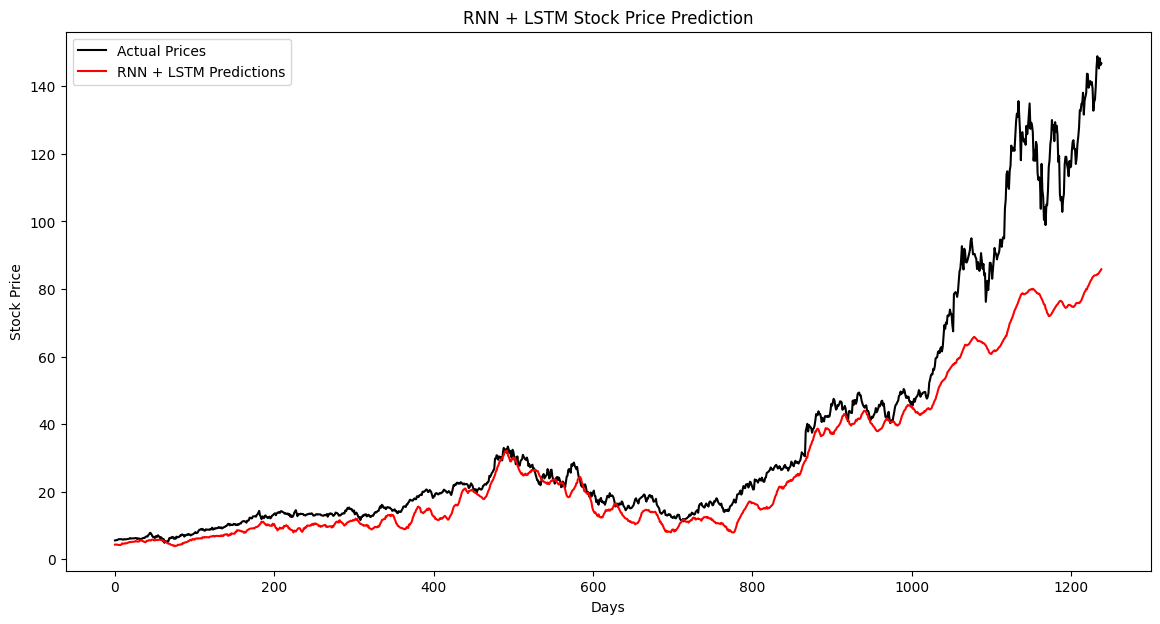

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_rnn_lstm, 'RNN + LSTM', y_pred_rnn_lstm)

CNN + LSTM

In [ ]:
# CNN + LSTM Hybrid Model
while cnn_lstm_mse >= 15 or cnn_lstm_directional_accuracy <= 0.48:
  cnn_lstm_model = Sequential([
      Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(time_step, 3)),
      MaxPooling1D(pool_size=2),
      LSTM(128, return_sequences=True),
      LSTM(128, return_sequences=False),
      Dense(32, activation='relu'),
      Dense(1)
  ])
  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_cnn_lstm.keras'
  # filePath = '/content/best_weights_cnn_lstm.keras'
  filePath = '/content/drive/MyDrive/Project/best_weights_cnn_lstm_highMSE_highDir.keras'
  filePath = '/content/best_weights_cnn_lstm_highMSE_highDir.keras'

  # Compile and fit the CNN + LSTM model
  cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #cnn_lstm_model.load_weights(filePath)

  progress_bar_cnn_lstm = TQDMProgressBar(epochs=20)  # Create the progress bar
  history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, callbacks=[progress_bar_cnn_lstm,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_cnn_lstm = scaler_y.inverse_transform(cnn_lstm_model.predict(X_test))
  cnn_lstm_mse = mean_squared_error(y_test_inv, y_pred_cnn_lstm)

  # Calculate directional accuracy
  cnn_lstm_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_cnn_lstm)
  print(f"CNN Model - Directional Accuracy: {cnn_lstm_directional_accuracy:.4f}")

  # Load existing model and check its MSE against current model
  cnn_lstm_model2 = load_model(filePath)
  y_pred_cnn_lstm2 = scaler_y.inverse_transform(cnn_lstm_model2.predict(X_test))
  cnn_lstm_mse2 = mean_squared_error(y_test_inv, y_pred_cnn_lstm2)
  cnn_lstm_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_cnn_lstm2)

  # Comment this out when not using the while loop
  if cnn_lstm_mse < (cnn_lstm_mse2) and cnn_lstm_directional_accuracy > clamp(cnn_lstm_directional_accuracy2 - 0.01, 0.47):
    cnn_lstm_model.save(filePath)
    print('saved')

# Save better model, load it's values
if cnn_lstm_mse < cnn_lstm_mse2 and cnn_lstm_directional_accuracy < cnn_lstm_directional_accuracy2:
  cnn_lstm_model.save(filePath)
else:
  cnn_lstm_model = cnn_lstm_model2
  y_pred_cnn_lstm = y_pred_cnn_lstm2
  cnn_lstm_mse = cnn_lstm_mse2




Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.86s/epoch, loss=1.17e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=1.17e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.82s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.82s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.39e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=1.44e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.44e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.48e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.36s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.36s/epoch, loss=9.32e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.63s/epoch, loss=9.32e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.63s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.33s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.33s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.17s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.17s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.13s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.29s/epoch, loss=1.17e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch, loss=7.81e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=7.81e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.26s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.52s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=8.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=8.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.04e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=2.04e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.6e-6] 


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.6e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.36s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.54s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:15,  7.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:15,  7.14s/epoch, loss=6.3e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.48s/epoch, loss=6.3e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.48s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.91s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.91s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=2.86e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:06,  4.45s/epoch, loss=2.86e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.39s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.39s/epoch, loss=8.42e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=8.42e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.66s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.91e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.60s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.60s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.28s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.28s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.06s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.06s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.83s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.08s/epoch, loss=1.06e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:13,  7.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:13,  7.04s/epoch, loss=8.62e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=8.62e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=2.48e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.48e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.75s/epoch, loss=2.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.75s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.53s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=8.3e-6]


Training Progress:  10%|█         | 2/20 [00:13<01:59,  6.64s/epoch, loss=8.3e-6]


Training Progress:  10%|█         | 2/20 [00:13<01:59,  6.64s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:36,  5.70s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:36,  5.70s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:22<01:22,  5.13s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:22<01:22,  5.13s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.97s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.35s/epoch, loss=1.11e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch, loss=9.96e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.14s/epoch, loss=9.96e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.14s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=2.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.63s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.86s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch, loss=8.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=8.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.39e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.85s/epoch, loss=2.39e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.85s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:29,  4.96s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:29,  4.96s/epoch, loss=1.59e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.59e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.52s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.48e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:37,  5.39s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.39s/epoch, loss=2.04e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=2.04e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.87e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.87e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.58s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=9.26e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=9.26e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.87s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.87s/epoch, loss=1.95e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.56s/epoch, loss=1.95e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.56s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.38s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.76s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
saved





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch, loss=7.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=7.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.21e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.21e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=9.55e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.83s/epoch, loss=9.55e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.83s/epoch, loss=2.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=2.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.47s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.17e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch, loss=7.64e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=7.64e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=2.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.55s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.55s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.39s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.58s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.89s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.43s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.43s/epoch, loss=9.01e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=9.01e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.05s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.05s/epoch, loss=1.13e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:10,  4.71s/epoch, loss=1.13e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5083
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch, loss=8.31e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=8.31e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.75s/epoch, loss=1.07e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch, loss=9.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=9.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.29e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.29e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.47s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.36e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.36e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.43s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch, loss=8.32e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:30,  5.05s/epoch, loss=8.32e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:30,  5.05s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=2.06e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.71s/epoch, loss=2.06e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.71s/epoch, loss=1.08e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.63s/epoch, loss=1.08e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.86s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<02:53,  9.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<02:53,  9.11s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:13<01:53,  6.31s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:13<01:53,  6.31s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:35,  5.63s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:35,  5.63s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:22<01:22,  5.13s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:22<01:22,  5.13s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:14,  4.96s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:21,  5.46s/epoch, loss=2.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch, loss=9.96e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.20s/epoch, loss=9.96e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.20s/epoch, loss=1.8e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.11s/epoch, loss=1.8e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.11s/epoch, loss=1.98e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.98e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch, loss=8.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.22s/epoch, loss=8.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.22s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.78s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch, loss=1.32e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.14s/epoch, loss=1.32e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.14s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.97s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.97s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.71s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.71s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=1.19e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=1.19e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.76s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.76s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.52s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=8.24e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=8.24e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.82s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.82s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.69s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.69s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.93s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.32s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.32s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.19s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.19s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.72s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.91s/epoch, loss=1.58e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=7.14e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=7.14e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=2.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=2.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.30s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=6.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=6.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.79s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.79s/epoch, loss=1.73e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.73s/epoch, loss=1.73e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=8.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=8.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.61s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.61s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=8.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=8.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=1.75e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.75e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.30s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.50s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.55s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.89s/epoch, loss=7.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=7.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=1.66e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.09s/epoch, loss=1.66e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.09s/epoch, loss=1.35e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.35e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.5e-6] 


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.76s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.35e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.63s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.16s/epoch, loss=8.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=8.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.83s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.07s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.58s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.90s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.30s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.30s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:32,  8.49s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:32,  8.49s/epoch, loss=2.1e-6] 


Training Progress:  15%|█▌        | 3/20 [00:21<01:57,  6.90s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:57,  6.90s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:37,  6.11s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:37,  6.11s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:21,  5.45s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:32,  6.19s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.30s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.30s/epoch, loss=9.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=9.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=3.04e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=3.04e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.78s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.03e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<03:06,  9.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<03:06,  9.84s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:14<01:58,  6.57s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:14<01:58,  6.57s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:35,  5.61s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:35,  5.61s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:25,  5.36s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:25,  5.36s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:18,  5.26s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:27,  5.85s/epoch, loss=1.21e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:08,  6.77s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:08,  6.77s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.27s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.27s/epoch, loss=1.6e-6] 


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.19s/epoch, loss=1.6e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.19s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.12s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.29s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.42s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.42s/epoch, loss=5.81e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=5.81e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.10s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.10s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.06s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.06s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:15,  5.05s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.27s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch, loss=7.8e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.24s/epoch, loss=7.8e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.24s/epoch, loss=2.42e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:25,  5.00s/epoch, loss=2.42e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:25,  5.00s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.01s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.01s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.97s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=1.25e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=1.25e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.60s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.91s/epoch, loss=1.75e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5066
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.26s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.26s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.87s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.87s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.81s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=8.42e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.00s/epoch, loss=8.42e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.00s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.06e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=2.06e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.73s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.93s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch, loss=1.43e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.43e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.63s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.63s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.51s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=1.39e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.39e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.29e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=2.29e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.54e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=9.38e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch, loss=1.29e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.29e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.65s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.65s/epoch, loss=2.15e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=2.15e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.35e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch, loss=8.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=8.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.25e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=8.56e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=8.56e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=1.42e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.52s/epoch, loss=1.42e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.52s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.64s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.90s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=7.66e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.83s/epoch, loss=7.66e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.83s/epoch, loss=1.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=2.57e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=2.57e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.65e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=9.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=9.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=1.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.76s/epoch, loss=1.06e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
CNN Model - Directional Accuracy: 0.4703
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.59s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.59s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.92s/epoch, loss=1.21e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.21e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=2.2e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=2.2e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.56s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.56s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4719
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.48s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.60s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=8.08e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=8.08e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=6.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=6.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=2.4e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=2.4e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.86s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch, loss=8.91e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=8.91e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=1.91e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.49s/epoch, loss=1.91e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.49s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.35s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=4.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.71s/epoch, loss=4.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.71s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.42s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.42s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.43s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:09<03:05,  9.78s/epoch]


Training Progress:   5%|▌         | 1/20 [00:09<03:05,  9.78s/epoch, loss=1e-5]


Training Progress:  10%|█         | 2/20 [00:14<01:57,  6.55s/epoch, loss=1e-5]


Training Progress:  10%|█         | 2/20 [00:14<01:57,  6.55s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:40,  5.89s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:40,  5.89s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:30,  5.64s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:30,  5.64s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:19,  5.28s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:27,  5.82s/epoch, loss=1.08e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=1.34e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.34e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.2e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.2e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.73e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=9.71e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=9.71e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.85s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.85s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.65s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=2.4e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=2.4e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=1.48e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.53s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.53s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.47e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.42s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.75s/epoch, loss=1.39e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch, loss=9.72e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=9.72e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=2.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.28s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.56s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.49s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.49s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.23s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.44s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=1.24e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.77s/epoch, loss=1.24e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.77s/epoch, loss=2.1e-6] 


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.43s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.43s/epoch, loss=1.96e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.28s/epoch, loss=1.96e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.28s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:02,  4.19s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.40s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
CNN Model - Directional Accuracy: 0.5033
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=1.26e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=1.26e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.57s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.57s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.80s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.9e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5050
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch, loss=7.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=7.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.35e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.33s/epoch, loss=1.35e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.33s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.24s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.60s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.83s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.83s/epoch, loss=7.62e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.77s/epoch, loss=7.62e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.77s/epoch, loss=2.58e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.44s/epoch, loss=2.58e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.44s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:03,  4.26s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.76e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.80s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.80s/epoch, loss=6.74e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.73s/epoch, loss=6.74e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.73s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:14,  4.40s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:14,  4.40s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.31s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.31s/epoch, loss=1.61e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.20s/epoch, loss=1.61e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.54s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.84s/epoch, loss=7.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.81s/epoch, loss=7.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.81s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch, loss=1.21e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.21e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.31s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.31s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.23s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.45s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=1.43e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.79s/epoch, loss=1.43e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.79s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:14,  4.63s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:14,  4.63s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.41s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.58s/epoch, loss=1.56e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.74s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.74s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.73s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:25,  4.73s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.44s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.44s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.27s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.27s/epoch, loss=1.14e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:02,  4.20s/epoch, loss=1.14e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.39s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch, loss=9.04e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:27,  4.85s/epoch, loss=9.04e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:27,  4.85s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.46s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.46s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.61s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.61s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.47s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.45e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.72s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.72s/epoch, loss=6.62e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:24,  4.68s/epoch, loss=6.62e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:24,  4.68s/epoch, loss=2.32e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:13,  4.35s/epoch, loss=2.32e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:13,  4.35s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:06,  4.18s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:06,  4.18s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:02,  4.16s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.36s/epoch, loss=1.06e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:48,  5.71s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:48,  5.71s/epoch, loss=1.1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.45s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.45s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.29s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.29s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:21<01:02,  4.17s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.39s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch, loss=9.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=9.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.44s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.44s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.29s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.76s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.76s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.47s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.47s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.27s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.27s/epoch, loss=1.3e-6] 


Training Progress:  25%|██▌       | 5/20 [00:21<01:02,  4.17s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.39s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.75s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.75s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=3.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=3.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:03,  4.20s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.5099
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch, loss=8.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=8.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.29s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.55s/epoch, loss=1.6e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:10<03:16, 10.32s/epoch]


Training Progress:   5%|▌         | 1/20 [00:10<03:16, 10.32s/epoch, loss=9.44e-6]


Training Progress:  10%|█         | 2/20 [00:14<02:00,  6.70s/epoch, loss=9.44e-6]


Training Progress:  10%|█         | 2/20 [00:14<02:00,  6.70s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:34,  5.54s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:19<01:34,  5.54s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:23<01:22,  5.16s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:23<01:22,  5.16s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:11,  4.79s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:22,  5.47s/epoch, loss=9.51e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch, loss=1.3e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.3e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.85s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.85s/epoch, loss=2.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.60s/epoch, loss=2.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.60s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.80s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch, loss=7.19e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.23s/epoch, loss=7.19e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.23s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.65s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=8.74e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.32s/epoch, loss=8.74e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.14s/epoch, loss=2.12e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.14s/epoch, loss=1.8e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.8e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=1.83e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=1.83e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.47s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.47s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:04,  4.32s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.65s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=9.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=9.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.69s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=1.45e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=1.45e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.37e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.38s/epoch, loss=1.37e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.38s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.57s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch, loss=9.68e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=9.68e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=1.88e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.68s/epoch, loss=1.88e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.68s/epoch, loss=1.8e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.8e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.55s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.86s/epoch, loss=1.29e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.88s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.88s/epoch, loss=5.53e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=5.53e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=2.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.81s/epoch, loss=2.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch, loss=9.21e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=9.21e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.61e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.23s/epoch, loss=1.61e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.59s/epoch, loss=1.5e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=8.84e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=8.84e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.84s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.81s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.81s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.48s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.48s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.34s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.90s/epoch, loss=7.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=7.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.56s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.56s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.37s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:48,  5.73s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:48,  5.73s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=3.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=3.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:47,  5.68s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:47,  5.68s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:25,  4.77s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:25,  4.77s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=1.83e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.83e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.72s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.19e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.73s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.73s/epoch, loss=6.51e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=6.51e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.87s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.87s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.53s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.53s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.33s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch, loss=7.16e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.18s/epoch, loss=7.16e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.18s/epoch, loss=1.75e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.86s/epoch, loss=1.75e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.50s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.50s/epoch, loss=1.23e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:04,  4.33s/epoch, loss=1.23e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.71s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:48,  5.71s/epoch, loss=8.06e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:24,  4.70s/epoch, loss=8.06e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:24,  4.70s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:13,  4.35s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:13,  4.35s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:09,  4.35s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:09,  4.35s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.22s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.43s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.75s/epoch, loss=1.28e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.28e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.52s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.52s/epoch, loss=1.1e-6] 


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.32s/epoch, loss=1.1e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.56s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:50,  5.83s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:50,  5.83s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.21s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.21s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=1.8e-6] 


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.50s/epoch, loss=1.8e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.50s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:04,  4.31s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.78s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.78s/epoch, loss=9.48e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=9.48e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:04,  4.27s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.52e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.78s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.78s/epoch, loss=9.7e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=9.7e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.44s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.44s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.25s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.25s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.71s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=8.1e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=8.1e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.7e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.65s/epoch, loss=1.7e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.88s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.49s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.49s/epoch, loss=9.95e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:42,  5.67s/epoch, loss=9.95e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:42,  5.67s/epoch, loss=1.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.21s/epoch, loss=1.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.21s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.76s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=2.57e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=2.57e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.7e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.7e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.75s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch, loss=9.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=9.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=7.77e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=2.1e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.70s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.70s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.13e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.59s/epoch, loss=1.13e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.88s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:30,  8.37s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:30,  8.37s/epoch, loss=1.59e-6]


Training Progress:  15%|█▌        | 3/20 [00:20<01:49,  6.47s/epoch, loss=1.59e-6]


Training Progress:  15%|█▌        | 3/20 [00:20<01:49,  6.47s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:29,  5.57s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:29,  5.57s/epoch, loss=1.3e-6] 


Training Progress:  25%|██▌       | 5/20 [00:29<01:18,  5.21s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:27,  5.81s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch, loss=9.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=9.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.25e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:11<03:42, 11.73s/epoch]


Training Progress:   5%|▌         | 1/20 [00:11<03:42, 11.73s/epoch, loss=8.04e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:15,  7.55s/epoch, loss=8.04e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:15,  7.55s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:48,  6.36s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:48,  6.36s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:33,  5.87s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:33,  5.87s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:22,  5.52s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:35,  6.37s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.40s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.40s/epoch, loss=1.14e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=1.14e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.94s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.94s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.75s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.65e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.33s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.33s/epoch, loss=8.06e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.50s/epoch, loss=8.06e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.50s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.17s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.17s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.89s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.15s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
saved





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.26s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.26s/epoch, loss=9.2e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=9.2e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=1.63e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.30s/epoch, loss=1.63e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.30s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.82s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.20s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch, loss=7.65e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.55s/epoch, loss=7.65e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.55s/epoch, loss=2.61e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=2.61e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.03s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.03s/epoch, loss=6.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=6.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.18s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch, loss=6.91e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.51s/epoch, loss=6.91e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.51s/epoch, loss=3.49e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=3.49e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.93e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.93e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch, loss=8.39e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.13s/epoch, loss=8.39e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.13s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.59e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.5033
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch, loss=6.69e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.22s/epoch, loss=6.69e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.22s/epoch, loss=2.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.13s/epoch, loss=2.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.13s/epoch, loss=2.38e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=2.38e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.91s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.38e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=7.96e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=7.96e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.47e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.13s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.13s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=1.42e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.02s/epoch, loss=1.42e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.02s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=9.65e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.06s/epoch, loss=9.65e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.06s/epoch, loss=2.38e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=2.38e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.8e-6] 


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.95s/epoch, loss=1.8e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=8.71e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=8.71e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.75s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.75s/epoch, loss=1.5e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.57s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.08e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.88s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.88s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.62s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch, loss=7.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=7.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.86s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.86s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.43e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.5e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=9.73e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=2.03e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=2.03e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.92s/epoch, loss=8.45e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=8.45e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.91e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.91e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.63e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.63e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.70s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4719
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch, loss=7.22e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=7.22e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.65s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.65s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.72s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=8.13e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=8.13e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=1.4e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.4e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.57e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=1.35e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.35e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=7.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=7.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.2e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.69s/epoch, loss=1.2e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch, loss=9.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=9.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=8.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=8.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.9e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=1.9e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.59s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.42s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.42s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.54e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=1.14e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.14e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.65s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.52s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.02e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.9e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.9e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.43s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.43s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.34s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.54s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=7.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=7.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=2.53e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=2.53e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.55e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.55e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.05e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=9.78e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=9.78e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.76s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch, loss=8.01e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=8.01e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.76e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.72s/epoch, loss=1.76e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.19e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch, loss=9.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=9.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.98s/epoch, loss=2.51e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.98s/epoch, loss=2e-6]   


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.97s/epoch, loss=2e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.97s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:15,  5.03s/epoch, loss=1.59e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.29s/epoch, loss=1.57e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=2.25e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=2.25e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.58s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=8e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=8e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.64s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.93s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:11<03:32, 11.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:11<03:32, 11.18s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:16,  7.56s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:16,  7.56s/epoch, loss=2.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:49,  6.42s/epoch, loss=2.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:49,  6.42s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:34,  5.91s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:34,  5.91s/epoch, loss=1.8e-6] 


Training Progress:  25%|██▌       | 5/20 [00:31<01:23,  5.58s/epoch, loss=1.8e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:34,  6.28s/epoch, loss=1.27e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.54s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.54s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.03s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.03s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:10,  4.72s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.47s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.47s/epoch, loss=8.28e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=8.28e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.63s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.90s/epoch, loss=1.71e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.42s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.42s/epoch, loss=9.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.25s/epoch, loss=9.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.25s/epoch, loss=1.64e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.64e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.32e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=1.32e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.89s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<01:59,  6.31s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<01:59,  6.31s/epoch, loss=8.15e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.66s/epoch, loss=8.15e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.66s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.09s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.09s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:18,  4.90s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:18,  4.90s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.97s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:18,  5.22s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.31s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.31s/epoch, loss=8.9e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=8.9e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.32s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.32s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.82s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.06s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.29s/epoch, loss=9.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.16s/epoch, loss=9.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.16s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.84s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.84s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.94s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.16s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:06,  6.65s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:06,  6.65s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.17s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.17s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:24,  5.30s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:24,  5.30s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.98s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.36s/epoch, loss=1.07e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch, loss=7.8e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=7.8e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.02s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.02s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.72s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.95s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:40,  5.58s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:40,  5.58s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.05s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.05s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.66s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.22s/epoch, loss=9.33e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.44s/epoch, loss=9.33e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.44s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.79s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.62s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.18s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.24s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.24s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:22,  5.14s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:22,  5.14s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.84s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.10s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=6.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.04s/epoch, loss=6.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.04s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=2.1e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.64s/epoch, loss=2.1e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.07s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.07s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:25,  5.00s/epoch, loss=1.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:25,  5.00s/epoch, loss=1.97e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.97e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.94s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:18,  5.20s/epoch, loss=1.17e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch, loss=6.51e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=6.51e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.96s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5083
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=9.66e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.26s/epoch, loss=9.66e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.26s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.14s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.14s/epoch, loss=2.09e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.81s/epoch, loss=2.09e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.81s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.77s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.95s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=7.64e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=7.64e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.79s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.11e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.20s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.20s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=1.6e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.79s/epoch, loss=1.6e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.79s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.60s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch, loss=7.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=7.99e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.07e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.26s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.26s/epoch, loss=8.88e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.08s/epoch, loss=8.88e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.08s/epoch, loss=3.8e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=3.8e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.51s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=8.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=8.43e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.81e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.92s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.92s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=8.97e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=8.97e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.47s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.13s/epoch, loss=7.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=7.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=2.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.06s/epoch, loss=2.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.06s/epoch, loss=1.4e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.75s/epoch, loss=1.4e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.75s/epoch, loss=1.06e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.06e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=9.07e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=9.07e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.74s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.74s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.11e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.11e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=7.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.52s/epoch, loss=7.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.52s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.8e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.8e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=9.9e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=9.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=9.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.71s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.71s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=8.58e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=8.58e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.76s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
saved





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=1.08e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=1.08e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
CNN Model - Directional Accuracy: 0.4670
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.65s/epoch, loss=2.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.65s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.84s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.49e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=6.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=6.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  5.00s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.99e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch, loss=7.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=7.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.07s/epoch, loss=1.68e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.70s/epoch, loss=1.68e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.70s/epoch, loss=2.01e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=2.01e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4703
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
CNN Model - Directional Accuracy: 0.4719
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=1.8e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.8e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.9e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.9e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.82e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.82e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch, loss=1.4e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.27s/epoch, loss=1.4e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.27s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.13s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.13s/epoch, loss=2.4e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.08s/epoch, loss=2.4e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.08s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.79s/epoch, loss=1.75e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.15s/epoch, loss=1.9e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.9e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.96e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.96e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=2e-6]   


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.64s/epoch, loss=2e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.01e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:09,  6.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:09,  6.84s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:23,  4.91s/epoch, loss=2.03e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:23,  4.91s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:09,  4.63s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.02s/epoch, loss=1.61e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=1.13e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.78s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.51e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=7.39e-6]


Training Progress:  10%|█         | 2/20 [00:17<01:34,  5.23s/epoch, loss=7.39e-6]


Training Progress:  10%|█         | 2/20 [00:17<01:34,  5.23s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:22<02:18,  8.15s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:22<02:18,  8.15s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:47,  6.74s/epoch, loss=1.92e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:47,  6.74s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:28,  5.90s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:34,  6.31s/epoch, loss=1.12e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.59s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.59s/epoch, loss=1.5e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=1.5e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.99s/epoch, loss=2.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.99s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.99s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.99s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.02s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.14s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:10,  6.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:10,  6.84s/epoch, loss=1.34e-5]


Training Progress:  10%|█         | 2/20 [00:12<01:44,  5.79s/epoch, loss=1.34e-5]


Training Progress:  10%|█         | 2/20 [00:12<01:44,  5.79s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:32,  5.43s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:32,  5.43s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.25s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.25s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.98s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.28s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.30s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.30s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.98e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.98e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.5050
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=1.3e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=1.3e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=1.84e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=1.84e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.75s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.75s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=9.01e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=9.01e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.32s/epoch, loss=1.7e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.21s/epoch, loss=1.7e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.21s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.81s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.12s/epoch, loss=1.52e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch, loss=7.99e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=7.99e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=2.53e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.97s/epoch, loss=2.53e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.97s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.94s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.94s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.95s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.08s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.00s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.00s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.05s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.05s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.36s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.36s/epoch, loss=2.42e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.19s/epoch, loss=2.42e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.19s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.51e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.09s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.33s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.34e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.34e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=1.22e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.06s/epoch, loss=2.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.06s/epoch, loss=1.28e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.75s/epoch, loss=1.28e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.75s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.97s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.12s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=1.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.09s/epoch, loss=1.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.09s/epoch, loss=1.28e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.28e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.59s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=7.61e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=7.61e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.69s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.48s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.48s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.90s/epoch, loss=2.21e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=2.21e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.80s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.55e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=1.26e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.26e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.78s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.01e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=8.93e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=8.93e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.59s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.59s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.51s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch, loss=8.96e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=8.96e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.69s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.51s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.51s/epoch, loss=1.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.5e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.95s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=2.19e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.51e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.91s/epoch, loss=9.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=9.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=6.45e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=6.45e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=2.76e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.53s/epoch, loss=2.76e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.53s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.29s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.56s/epoch, loss=1.73e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=9.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=9.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.92s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.92s/epoch, loss=7.82e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=7.82e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.05e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch, loss=1.09e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=1.09e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=2.35e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.47s/epoch, loss=2.35e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.47s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.28s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:17<01:08,  4.28s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:02,  4.20s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.44s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=7.25e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=7.25e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.08s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.65s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.65s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:04,  4.27s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.75e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.89s/epoch, loss=1.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.83s/epoch, loss=1.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.83s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.69s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=8.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=8.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.56e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch, loss=8.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=8.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.28s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.51s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=6.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=6.44e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.93s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.93s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.58s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.39s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch, loss=1.36e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.82s/epoch, loss=1.36e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.82s/epoch, loss=2.52e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=2.52e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=3.05e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=3.05e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.23s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.46s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=1.71e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=1.71e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=1.9e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.9e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.94e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.94e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.66s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.47e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch, loss=9.9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=9.9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:17,  4.56s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:17,  4.56s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.76s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.52s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.80s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.80s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.51s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.51s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.34s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  6.00s/epoch, loss=6.32e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=6.32e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.12e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.4e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.4e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.36s/epoch, loss=1.25e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.45e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<01:57,  6.20s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<01:57,  6.20s/epoch, loss=9.99e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=9.99e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.43s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.84s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.84s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.55s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.91s/epoch, loss=2.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.98s/epoch, loss=2.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
saved





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=8.48e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.29s/epoch, loss=8.48e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.29s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.00s/epoch, loss=1.8e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.73s/epoch, loss=1.8e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.73s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=9.62e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=9.62e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.87s/epoch, loss=3.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=3.37e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.45e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.11s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.39s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.39s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.78s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.03e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.97s/epoch, loss=6.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=6.12e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.47s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.47s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.54s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.54s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.43s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.59s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=6.27e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.30s/epoch, loss=6.27e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.30s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.52s/epoch, loss=1.73e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.52s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.35s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:13<04:17, 13.58s/epoch]


Training Progress:   5%|▌         | 1/20 [00:13<04:17, 13.58s/epoch, loss=8.66e-6]


Training Progress:  10%|█         | 2/20 [00:18<02:28,  8.24s/epoch, loss=8.66e-6]


Training Progress:  10%|█         | 2/20 [00:18<02:28,  8.24s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:22<01:49,  6.44s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:22<01:49,  6.44s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:27<01:32,  5.77s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:27<01:32,  5.77s/epoch, loss=1.2e-6] 


Training Progress:  25%|██▌       | 5/20 [00:31<01:18,  5.25s/epoch, loss=1.2e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:35,  6.37s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4719
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.31s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.84s/epoch, loss=1.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.11s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.16s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:31,  8.42s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:31,  8.42s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:20<01:50,  6.52s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:20<01:50,  6.52s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:32,  5.80s/epoch, loss=1.76e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:32,  5.80s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:23,  5.58s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:32,  6.19s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=9.26e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=9.26e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.61e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  5.00s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch, loss=6.16e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=6.16e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.67s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.67s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.50s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.50s/epoch, loss=1.14e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.58s/epoch, loss=1.14e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.72s/epoch, loss=5.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch, loss=5.72e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=5.72e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.98s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=2.14e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=2.14e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.54s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.56e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=8.58e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=8.58e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=3.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=3.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.55s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=1.29e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.32s/epoch, loss=9.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.32s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.80s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.80s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.90s/epoch, loss=1.73e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=1.34e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.06s/epoch, loss=1.34e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:31,  5.06s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.06s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.06s/epoch, loss=1.9e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.9e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:10,  4.72s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.02s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=8.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=8.75e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=1.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.80s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.80s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.48e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.14s/epoch, loss=7.2e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.20s/epoch, loss=7.2e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.20s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.12s/epoch, loss=2.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.12s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.78s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.88s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=8.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=8.02e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=7.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=7.98e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=2.08e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.72s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.71s/epoch, loss=1.5e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=2.1e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.95e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
CNN Model - Directional Accuracy: 0.5066
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch, loss=9.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.30s/epoch, loss=9.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.30s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.53s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.53s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:06,  4.43s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=2.33e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.36s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.36s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.53s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.56e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.89s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.56s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.56s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.38s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.56s/epoch, loss=1.19e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.79s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:49,  5.79s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:25,  4.77s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:25,  4.77s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.96s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.41e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.59s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.41s/epoch, loss=1.24e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.65s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.84s/epoch, loss=7.5e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=7.5e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.53s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.53s/epoch, loss=2.46e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=2.46e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.55s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.64s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch, loss=7.91e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=7.91e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.32s/epoch, loss=1.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.51s/epoch, loss=1.21e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.60s/epoch, loss=1.55e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.87s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.87s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.26s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.83e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.92s/epoch, loss=1.83e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.92s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.90s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.54e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch, loss=7.51e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=7.51e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.49s/epoch, loss=2.23e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.49s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.68s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.76s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.76s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:18,  4.90s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:18,  4.90s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:50,  5.81s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:50,  5.81s/epoch, loss=8.86e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=8.86e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.62s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.62s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.40s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.40s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=2.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.78s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:49,  5.78s/epoch, loss=6.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=6.67e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.40s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.34s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.55s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch, loss=6.84e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.26s/epoch, loss=6.84e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.26s/epoch, loss=2.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.90s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/epoch, loss=1.66e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.85s/epoch, loss=8.27e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=8.27e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:34,  5.25s/epoch, loss=2.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=2.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.89s/epoch, loss=2.32e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=2.32e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.56s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.39s/epoch, loss=1.27e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.39e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=7.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=7.18e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=1.85e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.85e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.01e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.46s/epoch, loss=2.01e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.46s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.32s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/epoch, loss=9.63e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch, loss=7.1e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=7.1e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:29,  5.25s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:29,  5.25s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.08e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=1.2e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=2e-6]  


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.13s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.13s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.10s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.10s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.75s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.07s/epoch, loss=1.07e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.87e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.35s/epoch, loss=1.87e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.35s/epoch, loss=2.99e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=2.99e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.39e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.07s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=2.56e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.56e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.55s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.33s/epoch, loss=1.88e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.33s/epoch, loss=1.7e-6] 


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.24s/epoch, loss=1.7e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.46s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=3.15e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=3.15e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.27s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.53s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.80s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:26,  4.80s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.75s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.75s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.46s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.46s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.31s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.54s/epoch, loss=1.4e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=7.76e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=7.76e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.61s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.61s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.44s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.38e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=1.24e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=1.24e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.33s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=1.97e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.97e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.73s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=1.25e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=1.25e-5]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.45s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:13<01:15,  4.45s/epoch, loss=2.16e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.28s/epoch, loss=2.16e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:08,  4.28s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.20s/epoch, loss=1.66e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.42s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch, loss=7.74e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=7.74e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.45s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.38e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=2.38e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.58s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.55e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.55e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=7.19e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.46s/epoch, loss=7.19e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.46s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.07s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.07s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:21,  5.12s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:21,  5.12s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.79s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.14s/epoch, loss=1.61e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=8.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:36,  5.34s/epoch, loss=8.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:36,  5.34s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.79s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.79s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch, loss=1.29e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.28s/epoch, loss=1.29e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.28s/epoch, loss=1.57e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.57e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.98s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.45s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5050
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.94s/epoch, loss=8.28e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=8.28e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.13s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.70s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.87s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.87s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.93s/epoch, loss=1.47e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=1.33e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=1.33e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.2e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=2.2e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.10s/epoch, loss=9.14e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.18s/epoch, loss=9.14e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.18s/epoch, loss=2.29e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.67s/epoch, loss=2.29e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.67s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.77s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.54s/epoch, loss=1.69e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.03e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=9.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=9.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=2.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.84e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.82s/epoch, loss=1.54e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.54e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.45s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.45s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.61s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.23e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:15<04:49, 15.25s/epoch]


Training Progress:   5%|▌         | 1/20 [00:15<04:49, 15.25s/epoch, loss=7.61e-6]


Training Progress:  10%|█         | 2/20 [00:20<02:43,  9.06s/epoch, loss=7.61e-6]


Training Progress:  10%|█         | 2/20 [00:20<02:43,  9.06s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:25<02:03,  7.27s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:25<02:03,  7.27s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:29<01:37,  6.12s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:29<01:37,  6.12s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:33<01:23,  5.54s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:33<01:41,  6.80s/epoch, loss=1.51e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.39s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:01,  6.39s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.17s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:33,  5.17s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.94s/epoch, loss=2.13e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.94s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.00s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.00s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.99s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.28s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.28s/epoch, loss=7.09e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=7.09e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.17s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.45e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.55s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.27s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.27s/epoch, loss=9.49e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=9.49e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.10s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.83s/epoch, loss=2e-6]   


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=2e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.59s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch, loss=9.15e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.50s/epoch, loss=9.15e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.50s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.92s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.63s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.12s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=2.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=2.21e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.88s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.3e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.73s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.38e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch, loss=7.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=7.11e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.46e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.56e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.11e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.11e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/epoch, loss=1.25e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=8.68e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.22s/epoch, loss=8.68e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.22s/epoch, loss=2.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=2.54e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.77s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.78s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.28e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.09s/epoch, loss=8.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.12s/epoch, loss=8.54e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.12s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.71s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.71s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.71e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.71e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.77s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=1.09e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=1.09e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.99s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.87s/epoch, loss=2.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=2.31e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.88s/epoch, loss=1.06e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=9.17e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=9.17e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.88s/epoch, loss=1.94e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.88s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.47e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.66s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.08s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=8.2e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.06s/epoch, loss=2e-6]  


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.68e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.96s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.16s/epoch, loss=1.73e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.04s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.04s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.69s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.69s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.81e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.81e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.47e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.16s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.16s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=1.82e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=1.37e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.37e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.50s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:29,  4.99s/epoch, loss=1.16e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:29,  4.99s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.99s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.99s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.99s/epoch, loss=1.5e-6] 


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.74s/epoch, loss=1.5e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=1.7e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.44s/epoch, loss=1.7e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.44s/epoch, loss=2.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=2.78e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.89e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.89e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.73s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.60s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.92s/epoch, loss=1.64e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4719
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch, loss=8.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=8.05e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=2.2e-6] 


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=2.2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.08s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.90s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.65s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.48e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=6.92e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=6.92e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  5.00s/epoch, loss=2.68e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=2.68e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.66s/epoch, loss=2.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=2.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.53s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4752
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.03s/epoch, loss=7.46e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=7.46e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.34e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.55e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.52s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
CNN Model - Directional Accuracy: 0.4703
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.91s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=2.21e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.49s/epoch, loss=2.21e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:11,  4.49s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.80s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.05s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.81s/epoch, loss=1.8e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.8e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.69s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.77e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.95s/epoch, loss=8.38e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=8.38e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/epoch, loss=1.5e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.74e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.46s/epoch, loss=1.74e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.65e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.86s/epoch, loss=8.27e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.83s/epoch, loss=8.27e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.83s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.16e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.47s/epoch, loss=1.16e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.55e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.88s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.88s/epoch, loss=6.93e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=6.93e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.62s/epoch, loss=2.43e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.62s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.39e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.82e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.82e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.24e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.15e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.85s/epoch, loss=1.9e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.9e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.62e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.89e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/epoch, loss=1.89e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.71s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.87s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.87s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=9.59e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.88s/epoch, loss=2.06e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.88s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.57s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.72e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.80s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.86s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.86s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=1.07e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.96s/epoch, loss=2.2e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=2.2e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.64s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.43s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.43s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.14e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.79s/epoch, loss=8.96e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.79s/epoch, loss=8.96e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.79s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=2.26e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.50s/epoch, loss=1.3e-6] 


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.3e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.34s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:03,  4.26s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.59s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch, loss=9.23e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=9.23e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.02s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=2.31e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.57s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:13,  4.57s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.43s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.82s/epoch, loss=5.41e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=5.41e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.82s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.46s/epoch, loss=2.14e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:15,  4.46s/epoch, loss=1.94e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.94e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.74s/epoch, loss=1.12e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.12e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.81s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.81s/epoch, loss=7.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=7.85e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.62s/epoch, loss=2.28e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.62s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.66s/epoch, loss=1.54e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.54e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.65s/epoch, loss=1.29e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.96s/epoch, loss=1.46e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.46e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.53s/epoch, loss=2.44e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.53s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.45s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.46e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.04s/epoch, loss=9.23e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=9.23e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.94s/epoch, loss=2.58e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=2.58e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.85s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=2.08e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.65s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.65s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.79s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.21s/epoch, loss=1.18e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.21s/epoch, loss=1.85e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=1.85e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.88s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.82s/epoch, loss=1.31e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.96s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4785
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch, loss=9.3e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=9.3e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.56s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:17,  4.56s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.67s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.47s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.65s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:51,  5.89s/epoch, loss=5.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=5.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.21s/epoch, loss=2.41e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.21s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.77s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.77s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.78s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.11s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/epoch, loss=8.98e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=8.98e-6]


Training Progress:  10%|█         | 2/20 [00:09<01:26,  4.80s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.48s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:14,  4.63s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:14,  4.63s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.44s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.60s/epoch, loss=1.2e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.90s/epoch, loss=8.41e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=8.41e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.05s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.71s/epoch, loss=2.36e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:19,  4.71s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.75s/epoch, loss=1.82e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.75s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/epoch, loss=1.32e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.71s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=9.06e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=9.06e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.61s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.49s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.57s/epoch, loss=1.65e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.70s/epoch, loss=1.36e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=9.03e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=9.03e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=2.52e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=2.52e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.55s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.65e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.39s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:04,  4.30s/epoch, loss=1.78e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.51s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.95s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:35,  5.29s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=2.07e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:20,  4.75s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.80s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:16,  4.80s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.55s/epoch, loss=1.18e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.93s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.98s/epoch, loss=9.3e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=9.3e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:33,  5.22s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=1.87e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.51s/epoch, loss=1.74e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.51s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:05,  4.35s/epoch, loss=1.45e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.69s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.84s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.84s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.86s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.82s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:22,  4.82s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.52s/epoch, loss=1.72e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.52s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.34s/epoch, loss=1.36e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.58s/epoch, loss=1.43e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
CNN Model - Directional Accuracy: 0.5017
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.94s/epoch, loss=1.08e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=1.08e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:27,  4.88s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:16,  4.52s/epoch, loss=2.24e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=2.24e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:09,  4.37s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.52s/epoch, loss=1.42e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.70s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.52s/epoch, loss=1.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.93s/epoch, loss=9.97e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=9.97e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.92e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.41s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:10,  4.41s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:07,  4.53s/epoch, loss=1.49e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.44e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.99s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.89s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.95e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.23e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=2.23e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.38s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.61s/epoch, loss=1.62e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Model - Directional Accuracy: 0.4736
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.97s/epoch, loss=7.55e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=7.55e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=2.1e-6] 


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.59s/epoch, loss=2.1e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.59s/epoch, loss=2.55e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.44s/epoch, loss=2.55e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.44s/epoch, loss=2.3e-6] 


Training Progress:  25%|██▌       | 5/20 [00:22<01:05,  4.34s/epoch, loss=2.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.55s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch, loss=8.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=8.37e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.01s/epoch, loss=1.88e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=1.88e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.46s/epoch, loss=1.79e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:11,  4.46s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.15e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  6.00s/epoch, loss=8.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=8.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=2.11e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.63s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.35e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.38e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=7.7e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.54s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.53s/epoch, loss=1.81e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:12,  4.53s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.41s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.74s/epoch, loss=1.49e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.05e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.90s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.61s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:18,  4.61s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.69s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.57s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.01s/epoch, loss=9.53e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=9.53e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:17,  4.57s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:18<01:10,  4.41s/epoch, loss=1.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:06,  4.46s/epoch, loss=1.77e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.62s/epoch, loss=1.34e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:55,  6.06s/epoch, loss=8.08e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=8.08e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:30,  5.03s/epoch, loss=3.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.93s/epoch, loss=3.25e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.93s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.61s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.83s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.59e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.99s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=2.45e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=2.45e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.77s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.51s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:12,  4.51s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.54s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.38e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.95s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:52,  5.95s/epoch, loss=9.46e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=9.46e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.95s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=2.14e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.60s/epoch, loss=2.14e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.60s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:08,  4.53s/epoch, loss=1.37e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.73s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.53s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.53s/epoch, loss=7.38e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:40,  5.60s/epoch, loss=7.38e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:40,  5.60s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:31,  5.39s/epoch, loss=2.47e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:31,  5.39s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.25s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.25s/epoch, loss=1.23e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:17,  5.14s/epoch, loss=1.23e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.32s/epoch, loss=1.42e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:21,  7.46s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:21,  7.46s/epoch, loss=8.16e-6]


Training Progress:  10%|█         | 2/20 [00:13<01:53,  6.29s/epoch, loss=8.16e-6]


Training Progress:  10%|█         | 2/20 [00:13<01:53,  6.29s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:38,  5.79s/epoch, loss=1.86e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:38,  5.79s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:23<01:32,  5.76s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:23<01:32,  5.76s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:28<01:22,  5.52s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:28<01:26,  5.79s/epoch, loss=1.46e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:22,  7.50s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:22,  7.50s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:13<01:58,  6.59s/epoch, loss=1.01e-5]


Training Progress:  10%|█         | 2/20 [00:13<01:58,  6.59s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:42,  6.04s/epoch, loss=2.16e-6]


Training Progress:  15%|█▌        | 3/20 [00:18<01:42,  6.04s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:33,  5.83s/epoch, loss=1.58e-6]


Training Progress:  20%|██        | 4/20 [00:24<01:33,  5.83s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:20,  5.39s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:27,  5.83s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:11,  6.91s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:11,  6.91s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:12<01:47,  5.99s/epoch, loss=1.03e-5]


Training Progress:  10%|█         | 2/20 [00:12<01:47,  5.99s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:33,  5.49s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:33,  5.49s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  4.97s/epoch, loss=1.68e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.32s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:11,  6.90s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:11,  6.90s/epoch, loss=9.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.52s/epoch, loss=9.53e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.52s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.33s/epoch, loss=2.22e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.33s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.21s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.21s/epoch, loss=1.4e-6] 


Training Progress:  25%|██▌       | 5/20 [00:26<01:17,  5.17s/epoch, loss=1.4e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.34s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
CNN Model - Directional Accuracy: 0.4967
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.57s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.57s/epoch, loss=1.17e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.55s/epoch, loss=1.17e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.55s/epoch, loss=2.5e-6] 


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.34s/epoch, loss=2.5e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.34s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.24s/epoch, loss=1.44e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.24s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.09s/epoch, loss=1.56e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.38s/epoch, loss=1.55e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch, loss=1.27e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.41s/epoch, loss=1.27e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.41s/epoch, loss=2.15e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.07s/epoch, loss=2.15e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.07s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.10s/epoch, loss=1.63e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:21,  5.10s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.90s/epoch, loss=1.22e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.10s/epoch, loss=1.13e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.46s/epoch, loss=7.09e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.49s/epoch, loss=7.09e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.49s/epoch, loss=2.2e-6] 


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.23s/epoch, loss=2.2e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.23s/epoch, loss=1.3e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.3e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.13s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.11s/epoch, loss=1.58e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:18,  5.25s/epoch, loss=1.22e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:03,  6.52s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:03,  6.52s/epoch, loss=9.13e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:33,  8.53s/epoch, loss=9.13e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:33,  8.53s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:54,  6.73s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:54,  6.73s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:35,  5.94s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:35,  5.94s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:21,  5.41s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:30<01:30,  6.06s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:03,  6.49s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:03,  6.49s/epoch, loss=8.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.66s/epoch, loss=8.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.66s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.14s/epoch, loss=1.77e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:27,  5.14s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.54e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.87s/epoch, loss=1.39e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.09s/epoch, loss=1.32e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.63s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.63s/epoch, loss=7.88e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.37s/epoch, loss=7.88e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.37s/epoch, loss=1.71e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=1.71e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.82s/epoch, loss=1.93e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.71s/epoch, loss=1.93e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.95s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4686
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.54s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.54s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=1.06e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.38s/epoch, loss=2.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=2.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.01s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.78e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.83s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.46e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.97s/epoch, loss=1.38e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.56s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:04,  6.56s/epoch, loss=8.81e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.50s/epoch, loss=8.81e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.50s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.29s/epoch, loss=1.79e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.29s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.64e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.97s/epoch, loss=1.76e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.84s/epoch, loss=1.76e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.19s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.47s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.47s/epoch, loss=9.93e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.33s/epoch, loss=9.93e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.33s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.99s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.99s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.77e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.93s/epoch, loss=1.6e-6] 


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.96s/epoch, loss=1.6e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.19s/epoch, loss=1.11e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.45s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.45s/epoch, loss=8.41e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.45s/epoch, loss=8.41e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:38,  5.45s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=2.18e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.20s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.15s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:22,  5.15s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:17,  5.14s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.33s/epoch, loss=1.42e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4950
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:06,  6.65s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:06,  6.65s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.65s/epoch, loss=9.52e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:41,  5.65s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.11s/epoch, loss=1.97e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.11s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.95s/epoch, loss=1.59e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.95s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.87s/epoch, loss=1.67e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.10s/epoch, loss=1.53e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.44s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.44s/epoch, loss=9.45e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.40s/epoch, loss=9.45e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.40s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.99e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.97s/epoch, loss=1.67e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  4.97s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:15,  5.06s/epoch, loss=1.33e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.28s/epoch, loss=1.1e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:06,  6.64s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:06,  6.64s/epoch, loss=7.98e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.36s/epoch, loss=7.98e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.36s/epoch, loss=1.63e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.63e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.26s/epoch, loss=1.7e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.7e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.96s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.80s/epoch, loss=1.53e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.17s/epoch, loss=9.69e-7]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.42s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.42s/epoch, loss=9.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=9.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.23s/epoch, loss=1.89e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:28,  5.23s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.02s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:20,  5.02s/epoch, loss=1.3e-6] 


Training Progress:  25%|██▌       | 5/20 [00:26<01:14,  5.00s/epoch, loss=1.3e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:18,  5.26s/epoch, loss=1.49e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4835
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.43s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:02,  6.43s/epoch, loss=1.1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=1.1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.24s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.98e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:22,  4.86s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.49e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:14,  4.68s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:13,  4.87s/epoch, loss=1.15e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.11s/epoch, loss=1.37e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.31s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:59,  6.31s/epoch, loss=1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=1e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=1.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.91s/epoch, loss=1.73e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:23,  4.91s/epoch, loss=2.26e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=2.26e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.48e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.85s/epoch, loss=1.59e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.34s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:00,  6.34s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:32,  8.46s/epoch, loss=7.47e-6]


Training Progress:  10%|█         | 2/20 [00:16<02:32,  8.46s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:20<01:51,  6.57s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:20<01:51,  6.57s/epoch, loss=3.7e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:33,  5.85s/epoch, loss=3.7e-6]


Training Progress:  20%|██        | 4/20 [00:25<01:33,  5.85s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:20,  5.36s/epoch, loss=1.41e-6]


Training Progress:  25%|██▌       | 5/20 [00:29<01:29,  5.99s/epoch, loss=1.21e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.50s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.50s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=1.23e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=1.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.06s/epoch, loss=1.65e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:26,  5.06s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.02s/epoch, loss=1.33e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:20,  5.02s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:11,  4.76s/epoch, loss=1.44e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.07s/epoch, loss=1.53e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch, loss=9.37e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=9.37e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=2.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.29s/epoch, loss=2.62e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:29,  5.29s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.19s/epoch, loss=1.86e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:23,  5.19s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:16,  5.10s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.39s/epoch, loss=1.51e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.16s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.11s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:31,  5.11s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=1.96e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.94s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.66e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:15,  4.71s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.68s/epoch, loss=1.51e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.00s/epoch, loss=1.35e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.5050
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.17s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:31,  8.40s/epoch, loss=1.02e-5]


Training Progress:  10%|█         | 2/20 [00:16<02:31,  8.40s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:56,  6.88s/epoch, loss=1.83e-6]


Training Progress:  15%|█▌        | 3/20 [00:21<01:56,  6.88s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:39,  6.19s/epoch, loss=1.48e-6]


Training Progress:  20%|██        | 4/20 [00:26<01:39,  6.19s/epoch, loss=1.91e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:26,  5.75s/epoch, loss=1.91e-6]


Training Progress:  25%|██▌       | 5/20 [00:31<01:35,  6.37s/epoch, loss=1.19e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN Model - Directional Accuracy: 0.4983
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.25s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.51s/epoch, loss=8.29e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.51s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.31s/epoch, loss=2.24e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:30,  5.31s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:18,  4.93s/epoch, loss=2.02e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:18,  4.93s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.86s/epoch, loss=1.43e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.19s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4917
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.19s/epoch, loss=1.42e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=1.42e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.34s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.19s/epoch, loss=2.09e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.19s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.86s/epoch, loss=1.53e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.86s/epoch, loss=2.2e-6] 


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.81s/epoch, loss=2.2e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.10s/epoch, loss=1.3e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4818
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=1.04e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.12s/epoch, loss=2.05e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.12s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.81s/epoch, loss=1.93e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:16,  4.81s/epoch, loss=1.74e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:09,  4.64s/epoch, loss=1.74e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.18e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:56,  6.15s/epoch, loss=7.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=7.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:34,  5.27s/epoch, loss=2e-6]   


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.82s/epoch, loss=2e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:21,  4.82s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.94s/epoch, loss=1.5e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:19,  4.94s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:12,  4.85s/epoch, loss=1.52e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.11s/epoch, loss=1.12e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN Model - Directional Accuracy: 0.4802
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.24s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.24s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.16s/epoch, loss=7.87e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:32,  5.16s/epoch, loss=2.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.97s/epoch, loss=2.72e-6]


Training Progress:  15%|█▌        | 3/20 [00:16<01:24,  4.97s/epoch, loss=1.89e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  5.00s/epoch, loss=1.89e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:19,  5.00s/epoch, loss=1.94e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.98s/epoch, loss=1.94e-6]


Training Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.08s/epoch, loss=1.33e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:57,  6.20s/epoch, loss=6.11e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.37s/epoch, loss=6.11e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:36,  5.37s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.19s/epoch, loss=2.17e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:28,  5.19s/epoch, loss=1.6e-6] 


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.86s/epoch, loss=1.6e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.86s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.76s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.17e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch, loss=7.3e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.31s/epoch, loss=7.3e-6]


Training Progress:  10%|█         | 2/20 [00:11<01:35,  5.31s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=1.74e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:27,  5.15s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=1.69e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.84s/epoch, loss=2.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.77s/epoch, loss=2.17e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.98s/epoch, loss=1.27e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
CNN Model - Directional Accuracy: 0.5000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.51s/epoch, loss=1.51e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=1.51e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:37,  5.44s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.93e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:25,  5.04s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.75s/epoch, loss=1.46e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:15,  4.75s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:08,  4.59s/epoch, loss=1.19e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/epoch, loss=1.28e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN Model - Directional Accuracy: 0.4851
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:58,  6.23s/epoch, loss=1.77e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.77e-5]


Training Progress:  10%|█         | 2/20 [00:11<01:39,  5.53s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.97s/epoch, loss=1.91e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.97s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.71e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:17,  4.85s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.67s/epoch, loss=1.62e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.99s/epoch, loss=1.16e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:52,  5.93s/epoch, loss=8.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=8.35e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:29,  4.97s/epoch, loss=1.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.69e-6]


Training Progress:  15%|█▌        | 3/20 [00:15<01:24,  4.95s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.75e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.64s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.48s/epoch, loss=1.57e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.76s/epoch, loss=1.61e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN Model - Directional Accuracy: 0.4769
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.02s/epoch, loss=7.69e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=7.69e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.92s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=2.27e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.85s/epoch, loss=1.52e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:17,  4.85s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/epoch, loss=1.38e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.09e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
CNN Model - Directional Accuracy: 0.4868
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch]


Training Progress:   5%|▌         | 1/20 [00:05<01:53,  5.98s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=1.11e-5]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.91s/epoch, loss=2.45e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.80s/epoch, loss=2.45e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:21,  4.80s/epoch, loss=1.4e-6] 


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.4e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:13,  4.62s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/epoch, loss=1.34e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:11,  4.78s/epoch, loss=1.31e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4884
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:54,  6.00s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=9e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:28,  4.93s/epoch, loss=1.6e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=1.6e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:18,  4.60s/epoch, loss=2.07e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=2.07e-6]


Training Progress:  20%|██        | 4/20 [00:19<01:14,  4.68s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:07,  4.49s/epoch, loss=1.28e-6]


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/epoch, loss=1.41e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.4901
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch]


Training Progress:   5%|▌         | 1/20 [00:06<01:53,  5.96s/epoch, loss=7.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=7.79e-6]


Training Progress:  10%|█         | 2/20 [00:10<01:32,  5.14s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=2.01e-6]


Training Progress:  15%|█▌        | 3/20 [00:14<01:20,  4.72s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.57e-6]


Training Progress:  20%|██        | 4/20 [00:20<01:18,  4.89s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.81s/epoch, loss=1.29e-6]


Training Progress:  25%|██▌       | 5/20 [00:24<01:14,  4.94s/epoch, loss=1.26e-6]

 1/39 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Model - Directional Accuracy: 0.5033
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   5%|▌         | 1/20 [00:07<02:04,  6.56s/epoch]


Training Progress:   5%|▌         | 1/20 [00:07<02:04,  6.56s/epoch, loss=7.35e-6]


Training Progress:  10%|█         | 2/20 [00:12<01:43,  5.76s/epoch, loss=7.35e-6]


Training Progress:  10%|█         | 2/20 [00:12<01:43,  5.76s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.32s/epoch, loss=2.02e-6]


Training Progress:  15%|█▌        | 3/20 [00:17<01:30,  5.32s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:24,  5.27s/epoch, loss=1.85e-6]


Training Progress:  20%|██        | 4/20 [00:21<01:24,  5.27s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:15,  5.03s/epoch, loss=1.26e-6]


Training Progress:  25%|██▌       | 5/20 [00:27<01:21,  5.42s/epoch, loss=1.21e-6]


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
CNN Model - Directional Accuracy: 0.4934
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step





Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_cnn_lstm, 'CNN + LSTM', y_pred_cnn_lstm2)

CNN + RNN Hybrid Model

In [ ]:
# CNN + RNN Hybrid Model
while cnn_rnn_mse >= 90 or cnn_rnn_directional_accuracy <= 0.48:
  cnn_rnn_model = Sequential([
      Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(time_step, 3)),
      MaxPooling1D(pool_size=2),
      SimpleRNN(128, activation='tanh', return_sequences=True),
      SimpleRNN(128, activation='tanh', return_sequences=False),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_cnn_rnn.keras'
  # filePath = '/content/best_weights_cnn_rnn.keras'
  filePath = '/content/drive/MyDrive/Project/best_weights_cnn_rnn_highMSE_highDir.keras'
  filePath = '/content/best_weights_cnn_rnn_highMSE_highDir.keras'

  # Compile and fit the CNN + RNN model
  cnn_rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #cnn_rnn_model.load_weights(filePath)

  progress_bar_cnn_rnn = TQDMProgressBar(epochs=20)  # Create the progress bar
  history_cnn_rnn = cnn_rnn_model.fit(X_train, y_train, epochs=20, batch_size=16, callbacks=[progress_bar_cnn_rnn,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_cnn_rnn = scaler_y.inverse_transform(cnn_rnn_model.predict(X_test))
  cnn_rnn_mse = mean_squared_error(y_test_inv, y_pred_cnn_rnn)

  # Calculate directional accuracy
  cnn_rnn_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_cnn_rnn)
  print(f"CNN Model - Directional Accuracy: {cnn_directional_accuracy:.4f}")

  # Load existing model and check its MSE against current model
  cnn_rnn_model2 = load_model(filePath)
  y_pred_cnn_rnn2 = scaler_y.inverse_transform(cnn_rnn_model2.predict(X_test))
  cnn_rnn_mse2 = mean_squared_error(y_test_inv, y_pred_cnn_rnn2)
  cnn_rnn_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_cnn_rnn2)

  # Comment this out when not using the while loop
  if cnn_rnn_mse < (cnn_rnn_mse2) and cnn_rnn_directional_accuracy > clamp(cnn_rnn_directional_accuracy2 - 0.01, 0.47):
    cnn_rnn_model.save(filePath)
    print('saved')

# Save better model, load it's values
if cnn_rnn_mse < cnn_rnn_mse2 and cnn_rnn_directional_accuracy < cnn_rnn_directional_accuracy2:
  cnn_rnn_model.save(filePath)
  print('saved')
else:
  cnn_rnn_model = cnn_rnn_model2
  y_pred_cnn_rnn = y_pred_cnn_rnn2
  cnn_rnn_mse = cnn_rnn_mse2

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_cnn_lstm, 'CNN + RNN', y_pred_cnn_rnn)

RNN + CNN + LSTM Hybrid Model

In [ ]:
# RNN + CNN + LSTM Hybrid Model
while rnn_cnn_lstm_mse >= 100 or rnn_cnn_lstm_directional_accuracy <= 0.48:
  rnn_cnn_lstm_model = Sequential([
      SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(time_step, 3)),
      Conv1D(filters=64, kernel_size=5, activation='relu'),
      MaxPooling1D(pool_size=2),
      LSTM(128, return_sequences=True),
      LSTM(128, return_sequences=False),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  # This is for older training data where we were only using close price as predictor.
  # filePath = '/content/drive/MyDrive/Project/best_weights_rnn_cnn_lstm.keras'
  # filePath = '/content/best_weights_rnn_cnn_lstm.keras'
  filePath = '/content/drive/MyDrive/Project/best_weights_rnn_cnn_lstm_highMSE_highDir.keras'
  filePath = '/content/best_weights_rnn_cnn_lstm_highMSE_highDir.keras'

  # Compile and fit the RNN + CNN + LSTM model
  rnn_cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
  #rnn_cnn_lstm_model.load_weights(filePath)

  progress_bar_rnn_cnn_lstm = TQDMProgressBar(epochs=20)  # Create the progress bar
  history_rnn_cnn_lstm = rnn_cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[progress_bar_rnn_cnn_lstm,early_stopping], validation_data=(X_test, y_test), verbose=0)

  # Predict + Check the MSE
  y_pred_rnn_cnn_lstm = scaler_y.inverse_transform(rnn_cnn_lstm_model.predict(X_test))
  rnn_cnn_lstm_mse = mean_squared_error(y_test_inv, y_pred_rnn_cnn_lstm)

  # Calculate directional accuracy
  rnn_cnn_lstm_directional_accuracy = calculate_directional_accuracy(y_test_inv, y_pred_rnn_cnn_lstm)
  print(f"RNN Model - Directional Accuracy: {rnn_cnn_lstm_directional_accuracy:.4f}")

  # Load existing model and check its MSE against current model
  rnn_cnn_lstm_model2 = load_model(filePath)
  y_pred_rnn_cnn_lstm2 = scaler_y.inverse_transform(rnn_cnn_lstm_model2.predict(X_test))
  rnn_cnn_lstm_mse2 = mean_squared_error(y_test_inv, y_pred_rnn_cnn_lstm2)
  rnn_cnn_lstm_directional_accuracy2 = calculate_directional_accuracy(y_test_inv, y_pred_rnn_cnn_lstm2)

    # Comment this out when not using the while loop
  if rnn_cnn_lstm_mse < (rnn_cnn_lstm_mse2) and rnn_cnn_lstm_directional_accuracy > clamp(rnn_cnn_lstm_directional_accuracy2 - 0.01, 0.47):
    rnn_cnn_lstm_model.save(filePath)
    print('saved')

# Save better model, load it's values
if rnn_cnn_lstm_mse < rnn_cnn_lstm_mse2 and rnn_cnn_lstm_directional_accuracy < rnn_cnn_lstm_directional_accuracy2:
  rnn_cnn_lstm_model.save(filePath)
else:
  rnn_cnn_lstm_model = rnn_cnn_lstm_model2
  y_pred_rnn_cnn_lstm = y_pred_rnn_cnn_lstm2
  rnn_cnn_lstm_mse = rnn_cnn_lstm_mse2

In [ ]:
# Plot training & validation accuracy values
drawGraphs(history_rnn_cnn_lstm, 'RNN + CNN + LSTM', y_pred_rnn_cnn_lstm)

Predictions and Evaluation

In [ ]:
# Visualization: Compare Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='black')
plt.plot(y_pred_rnn, label='Simple RNN Predictions', color='purple')
plt.plot(y_pred_cnn, label='CNN Predictions', color='red')
plt.plot(y_pred_lstm, label='LSTM Predictions', color='orange')
plt.plot(y_pred_rnn_lstm, label='RNN + LSTM Predictions', color='blue')
plt.plot(y_pred_cnn_lstm, label='CNN + LSTM Predictions', color='yellow')
plt.plot(y_pred_cnn_rnn, label='CNN + RNN Predictions', color='cyan')
plt.plot(y_pred_rnn_cnn_lstm, label='RNN + CNN + LSTM Predictions', color='green')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Hybrid Models")
plt.legend()
plt.show()

In [ ]:
# Print MSE for each model
print('MSE for Each Model:')
print(f'RNN + LSTM Model MSE: {rnn_lstm_mse}')
print(f'CNN + LSTM Model MSE: {cnn_lstm_mse}')
print(f'CNN + RNN Model MSE: {cnn_rnn_mse}')
print(f'RNN + CNN + LSTM Model MSE: {rnn_cnn_lstm_mse}')
print()

# Future price prediction
last_60_days = data[['Volume', 'High', 'Low', 'Close']][-time_step:].values  # Use all features for scaling

# Scale the features (excluding 'Close' price)
last_60_days_scaled = scaler_X.transform(last_60_days[:, :-1])

# Reshape to (1, time_step, number_of_features)
X_input = last_60_days_scaled.reshape(1, time_step, last_60_days_scaled.shape[1])

# Predictions with each hybrid model
rnn_lstm_prediction = scaler_y.inverse_transform(rnn_lstm_model.predict(X_input))
cnn_lstm_prediction = scaler_y.inverse_transform(cnn_lstm_model.predict(X_input))
cnn_rnn_prediction = scaler_y.inverse_transform(cnn_rnn_model.predict(X_input))
rnn_cnn_lstm_prediction = scaler_y.inverse_transform(rnn_cnn_lstm_model.predict(X_input))

# Print predictions
print()
print('Price Predictions by Each Model:')
print(f'RNN + LSTM prediction for next day: {rnn_lstm_prediction[0, 0]}')
print(f'CNN + LSTM prediction for next day: {cnn_lstm_prediction[0, 0]}')
print(f'CNN + RNN prediction for next day: {cnn_rnn_prediction[0, 0]}')
print(f'RNN + CNN + LSTM prediction for next day: {rnn_cnn_lstm_prediction[0, 0]}')

Calculate directional accuracy

In [ ]:
# Print out the directional accuracy for each model
print(f"CNN Model - Directional Accuracy: {cnn_directional_accuracy:.4f}")
print(f"RNN Model - Directional Accuracy: {rnn_directional_accuracy:.4f}")
print(f"LSTM Model - Directional Accuracy: {lstm_directional_accuracy:.4f}")
print(f"RNN + LSTM Model - Directional Accuracy: {rnn_lstm_directional_accuracy:.4f}")
print(f"CNN + LSTM Model - Directional Accuracy: {cnn_lstm_directional_accuracy:.4f}")
print(f"CNN + RNN Model - Directional Accuracy: {cnn_rnn_directional_accuracy:.4f}")
print(f"RNN + CNN + LSTM Model - Directional Accuracy: {rnn_cnn_lstm_directional_accuracy:.4f}")
print()
# Print out the directional accuracy for each model
print(f"CNN Model - Directional Accuracy: {cnn_directional_accuracy2:.4f}")
print(f"RNN Model - Directional Accuracy: {rnn_directional_accuracy2:.4f}")
print(f"LSTM Model - Directional Accuracy: {lstm_directional_accuracy2:.4f}")
print(f"RNN + LSTM Model - Directional Accuracy: {rnn_lstm_directional_accuracy2:.4f}")
print(f"CNN + LSTM Model - Directional Accuracy: {cnn_lstm_directional_accuracy2:.4f}")
print(f"CNN + RNN Model - Directional Accuracy: {cnn_rnn_directional_accuracy2:.4f}")
print(f"RNN + CNN + LSTM Model - Directional Accuracy: {rnn_cnn_lstm_directional_accuracy2:.4f}")

In [ ]:
rnn_lstm_f1 = custom_f1_score(y_test_inv, rnn_lstm_prediction, threshold=0.5)
cnn_lstm_f1 = custom_f1_score(y_test_inv, cnn_lstm_prediction, threshold=0.5)
cnn_rnn_f1 = custom_f1_score(y_test_inv, cnn_rnn_prediction, threshold=0.5)
rnn_cnn_lstm_f1 = custom_f1_score(y_test_inv, rnn_cnn_lstm_prediction, threshold=0.5)

print(f"RNN LSTM F1-Score (within 50%): {rnn_lstm_f1:.4f}")
print(f"CNN LSTM F1-Score (within 50%): {cnn_lstm_f1:.4f}")
print(f"CNN RNN F1-Score (within 50%): {cnn_rnn_f1:.4f}")
print(f"RNN CNN LSTM F1-Score (within 50%): {rnn_cnn_lstm_f1:.4f}")

In [ ]:
rnn_lstm_scores = [rnn_lstm_f1]
cnn_lstm_scores = [cnn_lstm_f1]
cnn_rnn_scores = [cnn_rnn_f1]
rnn_cnn_lstm_scores = [rnn_cnn_lstm_f1]

metrics = ['F1-Score']

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars with adjusted positions
rects1 = ax.bar(x - 1.5*width, rnn_lstm_scores, width, label='RNN LSTM')
rects2 = ax.bar(x - 0.5*width, cnn_lstm_scores, width, label='CNN LSTM')
rects3 = ax.bar(x + 0.5*width, cnn_rnn_scores, width, label='CNN RNN')
rects4 = ax.bar(x + 1.5*width, rnn_cnn_lstm_scores, width, label='CNN RNN LSTM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: RNN CNN, CNN LSTM, CNN RNN, CNN RNN LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# Calculate MAPE
rnn_lstm_mape = mean_absolute_percentage_error(y_test_inv, y_pred_rnn_lstm)
cnn_lstm_mape = mean_absolute_percentage_error(y_test_inv, y_pred_cnn_lstm)
rnn_cnn_lstm_mape = mean_absolute_percentage_error(y_test_inv, y_pred_rnn_cnn_lstm)
cnn_rnn_mape = mean_absolute_percentage_error(y_test_inv, y_pred_cnn_rnn)

print("### MAPE (Mean Absolute Percentage Error) ###")
print(f'RNN + LSTM MAPE: {rnn_lstm_mape:.2f}%')
print(f'CNN + LSTM MAPE: {cnn_lstm_mape:.2f}%')
print(f'RNN + CNN + LSTM MAPE: {rnn_cnn_lstm_mape:.2f}%')
print(f'CNN + RNN MAPE: {cnn_rnn_mape:.2f}%')

In [ ]:
# Calculate RMSE
rnn_lstm_rmse = root_mean_squared_error(y_test_inv, y_pred_rnn_lstm)
cnn_lstm_rmse = root_mean_squared_error(y_test_inv, y_pred_cnn_lstm)
rnn_cnn_lstm_rmse = root_mean_squared_error(y_test_inv, y_pred_rnn_cnn_lstm)
cnn_rnn_rmse = root_mean_squared_error(y_test_inv, y_pred_cnn_rnn)

print("### RMSE (Root Mean Squared Error) ###")
print(f'RNN + LSTM RMSE: {rnn_lstm_rmse:.4f}')
print(f'CNN + LSTM RMSE: {cnn_lstm_rmse:.4f}')
print(f'RNN + CNN + LSTM RMSE: {rnn_cnn_lstm_rmse:.4f}')
print(f'CNN + RNN RMSE: {cnn_rnn_rmse:.4f}')

In [ ]:
# Calculate MASE
rnn_lstm_mase = mean_absolute_scaled_error(y_test_inv, y_pred_rnn_lstm, train_data)
cnn_lstm_mase = mean_absolute_scaled_error(y_test_inv, y_pred_cnn_lstm, train_data)
rnn_cnn_lstm_mase = mean_absolute_scaled_error(y_test_inv, y_pred_rnn_cnn_lstm, train_data)
cnn_rnn_mase = mean_absolute_scaled_error(y_test_inv, y_pred_cnn_rnn, train_data)

print("### MASE (Mean Absolute Scaled Error) ###")
print(f'RNN + LSTM MASE: {rnn_lstm_mase:.4f}')
print(f'CNN + LSTM MASE: {cnn_lstm_mase:.4f}')
print(f'RNN + CNN + LSTM MASE: {rnn_cnn_lstm_mase:.4f}')
print(f'CNN + RNN MASE: {cnn_rnn_mase:.4f}')


In [ ]:
metrics = {
    'Model': ['Simple RNN', 'CNN', 'LSTM', 'RNN + LSTM', 'CNN + LSTM', 'RNN + CNN + LSTM', 'CNN + RNN'],
    'MSE': [rnn_lstm_mse, cnn_lstm_mse, rnn_cnn_lstm_mse, rnn_lstm_mse, cnn_lstm_mse, rnn_cnn_lstm_mse, cnn_rnn_mse],
    'MAPE': [rnn_lstm_mape, cnn_lstm_mape, rnn_cnn_lstm_mape, rnn_lstm_mape, cnn_lstm_mape, rnn_cnn_lstm_mape, cnn_rnn_mape],
    'RMSE': [rnn_lstm_rmse, cnn_lstm_rmse, rnn_cnn_lstm_rmse, rnn_lstm_rmse, cnn_lstm_rmse, rnn_cnn_lstm_rmse, cnn_rnn_rmse],
    'MASE': [rnn_lstm_mase, cnn_lstm_mase, rnn_cnn_lstm_mase, rnn_lstm_mase, cnn_lstm_mase, rnn_cnn_lstm_mase, cnn_rnn_mase]
}

# Convert to DataFrame for easier manipulation
metrics_df = pd.DataFrame(metrics)

# Plotting all evaluation metrics on separate bar charts

# 1. Plot MSE
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['MSE'], color='blue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. Plot MAPE
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['MAPE'], color='orange')
plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Plot RMSE
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['RMSE'], color='green')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 4. Plot MASE
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['MASE'], color='red')
plt.title('Mean Absolute Scaled Error (MASE) Comparison')
plt.xlabel('Model')
plt.ylabel('MASE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Get the current date
current_date = datetime.now()

# Create a dictionary with the predictions and the date
today_predictions = {
    'Date': [current_date.strftime('%m-%d-%y')],
    'CNN Predictions': cnn_prediction[0, 0],
    'RNN Predictions': rnn_prediction[0, 0],
    'LSTM Predictions': lstm_prediction[0, 0],
    'RNN + LSTM Predictions': rnn_lstm_prediction[0, 0],
    'CNN + LSTM Predictions': cnn_lstm_prediction[0, 0],
    'CNN + RNN Predictions': cnn_rnn_prediction[0, 0],
    'RNN + CNN + LSTM Predictions': rnn_cnn_lstm_prediction[0, 0],
    'Actual Prices': [None]
}

# Get the actual price
actual_price = yf.Ticker("NVDA").history(period='1d')['Close'].iloc[-1]

# Create a DataFrame
today_df = pd.DataFrame(today_predictions)

# Specify the file path in Google Drive
file_name = '/content/drive/My Drive/Project/STOCKPRED-OCT31.xlsx'
try:
    existing_df = pd.read_excel(file_name)
    existing_df.loc[existing_df.index[-1], 'Actual Prices'] = actual_price
    next_date = datetime.strptime(existing_df['Date'].iloc[-1], '%m-%d-%y') + timedelta(days=1)
    today_df['Date'] = [next_date.strftime('%m-%d-%y')]
    combined_df = pd.concat([existing_df, today_df], ignore_index=True)

except FileNotFoundError:
    combined_df = today_df

combined_df.to_excel(file_name, index=False)

print(f"Predictions for {combined_df['Date'].iloc[-1]} saved to {file_name}.")

files.download(file_name)